In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
import math
import os
import glob
from statistics import mean, stdev

# import matplotlib
# matplotlib.use('module://ipympl.backend_nbagg')
# %matplotlib widget

# import PyQt5
# import os
# os.environ["QT_API"] = "pyqt5"

In [2]:
sys.path.append("/Users/pnr5sh/Documents/phd/mmmp/")
import sidchaini.sidhelpers as sidhelpers

In [3]:
#reading in meta data from sid's dir
header = ['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC', 'Obj. Type',
          'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)', 'From', 'Telescope',
          'Instrument', 'Observer/s', 'Reducer/s', 'Source group', 'Public', 'Associated groups',
          'End prop. period', 'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
          'Extinction-Corrected', 'WL Medium','WL Units', 'Flux Unit Coefficient', 'Spec. units',
          'Flux Calibrated By', 'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
          'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib', 'Publish', 'Remarks',
          'Created by', 'Creation date']
all_spec_meta = pd.read_csv('../sidchaini/1. download ALL wise data/wiserep_spectra_combined.csv', header='infer')# names=header, delimiter=', ', skiprows=1)
all_spec_meta.columns

Index(['wise_objid', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [4]:
# filters for specific types
multi_types = (all_spec_meta['Obj. Type']=='SN IIb')|(all_spec_meta['Obj. Type']=='SN Ib')|(all_spec_meta['Obj. Type']=='SN Ic')|(all_spec_meta['Obj. Type']=='SLSN-I')|(all_spec_meta['Obj. Type']=='SLSN-II')|(all_spec_meta['Obj. Type']=='SN IIn')

#filters for ZTF/P60 data
p60 = (all_spec_meta['Telescope']=='P60')
sedm = (all_spec_meta['Instrument']=='SEDM')

#creating filters based on types for big DF
iib = (all_spec_meta['Obj. Type']=='SN IIb')
ib = (all_spec_meta['Obj. Type']=='SN Ib')
ic = (all_spec_meta['Obj. Type']=='SN Ic')
slsni = (all_spec_meta['Obj. Type']=='SLSN-I')
slsnii = (all_spec_meta['Obj. Type']=='SLSN-II')
iin = (all_spec_meta['Obj. Type']=='SN IIn')

In [5]:
#creates ztf_info*.csv files for submitting batch queries to ZTF FP server

types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SLSN-I', 'SLSN-II', 'SN IIn']
types_flags = [iib, ib, ic, slsni, slsnii, iin]

for i,types in enumerate(types_flags):
    objs = all_spec_meta.loc[types&p60&sedm,'IAU name'].unique().tolist() #list of IIb names

    ras, decs, jd_starts, jd_ends, obj_name = [],[],[],[],[]
    for j in range(len(objs)):
        ra = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'Obj. RA'].iloc[0]
        dec = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'Obj. DEC'].iloc[0]
        jd = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'JD'].iloc[0] #JD of spectra taken for individ obj
        name = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'IAU name'].iloc[0]
        ras.append(ra)
        decs.append(dec)
        jd_starts.append(jd-50)
        jd_ends.append(jd+150)
        obj_name.append(name)
    
    typs = [types_str[i]]*len(ras)
    d = {'ra':ras, 'dec':decs, 'jd_start':jd_starts, 'jd_end':jd_ends, 'obj_name':obj_name, 'type':typs}
    ztf_info = pd.DataFrame(d)
    ztf_info.to_csv(f"./ztf_fp_info_for_{types_str[i]}.csv", index=False)

In [6]:
# creating df of only objects meeting our target types, from ZTF 
mp_spec_df = all_spec_meta.loc[multi_types&p60&sedm]

In [7]:
# types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SLSN-I']
# types_flags = [iib, ib, ic, slsni]

# for i,types in enumerate(types_flags):
#     objs = all_spec_meta.loc[types&p60&sedm,'IAU name'].unique().tolist() #list of IIb names

#     ras, decs, jd_starts, jd_ends, obj_name = [],[],[],[],[]
#     for j in range(len(objs)):
#         ra = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'Obj. RA'].iloc[0]

In [8]:
#read in ztf lc data into DF and also header info
#isolate ra/dec from header and cross-match to mp_spec_df values to find corresponding SN
#rename file 

def rename_via_coords(datadir,df2match):
    filenames = [datadir+f for f in os.listdir(datadir)]

    ra_str = '# Requested input R.A. = '
    dec_str = '# Requested input Dec. = '
    for i,filename in enumerate(filenames):
        ra = float()
        dec = float()
        with open(filename, 'r') as file:
            header = [next(file) for x in range(54)]
            for line in header:
                if line.startswith(ra_str):
                    ra = float(line[len(ra_str):-8])
                if line.startswith(dec_str):
                    dec = float(line[len(dec_str):-8])
        idx = [df2match['Obj. RA'].sub(ra).abs().idxmin()] # list of index matching the ra
        if len(idx)>0:
            name = df2match.loc[idx[0],'IAU name'][3:]
            savefile = datadir+name+'_fp_lc.txt'
            #rename the file w/ the IAU name
            os.system(f"cp {filename} {savefile}")
        else:
            print(f"Unable to find closest match to RA={ra}")

In [ ]:
#only run if files haven't been renamed 
#if running on already renamed files, os will recognize they are identical and skip

rename_via_coords('./ztf_fp_data/ib/',mp_spec_df)
rename_via_coords('./ztf_fp_data/ic/',mp_spec_df)
rename_via_coords('./ztf_fp_data/iib/',mp_spec_df)
rename_via_coords('./ztf_fp_data/iin/',mp_spec_df)
rename_via_coords('./ztf_fp_data/slsni/',mp_spec_df)
rename_via_coords('./ztf_fp_data/slsnii/',mp_spec_df)

In [93]:
# #check if the matched file names match the object names

# li = mp_spec_df.loc[mp_spec_df['Obj. Type']=='SN Ib', 'IAU name'].sort_values().unique()
# for l in li:
#     print(l)

In [23]:
# dropping bad obs
# centering LCs around date of first spectra (-50, +150 days)
# creating mag and mag_err cols
# dropping points w/ e_mag>2 mags
# creating mjd col

def create_ztf_lc_dfs(datadir, sn_type, check_names=False):
        files = sorted(glob.glob(datadir+'*_fp_lc.txt'))
        ztf_info_df = pd.read_csv(f'ztf_fp_info_for_{sn_type}.csv')

        if (sn_type == 'SN IIb') or (sn_type =='SN IIn'):
                startindx = 18
        elif (sn_type == 'SN Ic') or (sn_type =='SN Ib'):
                startindx = 17
        elif sn_type == 'SLSN-I':
                startindx = 20
        elif sn_type == 'SLSN-II':
                startindx = 21
        else:
                print(f'SN type {sn_type} unsupported or not in format SN XX / SLSN-XX')
                return

        sn_names, lc_dfs = [],[]
        for file in files:
                sn_name = file[startindx:-10] #NOTE: FIRST INDEX CHANGES W/ DATADIR NAME LENGTH
                if check_names:
                        print(sn_name)
                        continue
                
                sn_names.append(sn_name)

                cols = ['index', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix',
                        'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
                        'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc',
                        'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr',
                        'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
                df = pd.read_csv(file, names=cols, header=None, sep=" ", skiprows=54)
                df = df.set_index(df['index'])  # manually setting indeces
                df = df.drop(columns=['index']) # drop duplicated index 
                df = df[(df['infobitssci'] < 33554432) & (df['scisigpix'] <= 25) & (df['sciinpseeing'] <= 4) & (df['forcediffimflux']!=-99999.0)].reset_index(drop=True) #clean according to docs

                # cut df down to -50 days to +365 days centered on date of first spectra
                # time window included in ztf_fp_info*csv files for each obj type
                obj = ztf_info_df.loc[ztf_info_df['obj_name'].str[3:]==sn_name]
                start_jd = obj['jd_start'].iloc[0]
                end_jd = obj['jd_end'].iloc[0]
                df_cut = df.loc[(df['jd']<end_jd)&(df['jd']>start_jd)] #only selecting points that fall within specified time window
                df_cut = df_cut.reset_index(drop=True)
                df_cut = df_cut.infer_objects() #infering dtype of columns

                mag = df_cut['zpdiff'] - 2.5 * np.log10(df_cut['forcediffimflux'])
                sigma_mag = 1.0857 * df_cut['forcediffimfluxunc']/df_cut['forcediffimflux']
                df_cut['mag'] = mag
                df_cut['e_mag'] = sigma_mag
                df_cut = df_cut.loc[(df_cut['forcediffimflux']>0) & (df_cut['e_mag']<2)].reset_index(drop=True) #only selecting points w/ non-nan mags and errorbars less than 2 mags
                df_cut['mjd'] = df_cut['jd']-2400000.5

                lc_dfs.append(df_cut)

        return sn_names, lc_dfs

In [28]:
sn_names_ib, lc_dfs_ib = create_ztf_lc_dfs('./ztf_fp_data/ib/','SN Ib')
sn_names_ic, lc_dfs_ic = create_ztf_lc_dfs('./ztf_fp_data/ic/','SN Ic')
sn_names_iib, lc_dfs_iib = create_ztf_lc_dfs('./ztf_fp_data/iib/','SN IIb')
sn_names_iin, lc_dfs_iin = create_ztf_lc_dfs('./ztf_fp_data/iin/','SN IIn')
sn_names_slsni, lc_dfs_slsni = create_ztf_lc_dfs('./ztf_fp_data/slsni/','SLSN-I')
sn_names_slsnii, lc_dfs_slsnii = create_ztf_lc_dfs('./ztf_fp_data/slsnii/','SLSN-II')

/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/User

In [36]:
# plotting to see if data exists around SN + data spread across filters + multi-peakedness
def plot_all_ztf_lcs(lc_dfs,sn_names,interactive=False,save=False,datadir='./figures/ztf_lcs/'):
    if not interactive:
        %matplotlib inline
    else:
        %matplotlib widget

    for i in range(len(lc_dfs)):
        gband = (lc_dfs[i]['filter']=='ZTF_g')
        rband = (lc_dfs[i]['filter']=='ZTF_r')
        iband = (lc_dfs[i]['filter']=='ZTF_i')

        plt.figure(figsize=(8,6))
        plt.errorbar(lc_dfs[i].loc[gband, 'mjd'], lc_dfs[i].loc[gband, 'mag'], yerr=lc_dfs[i].loc[gband, 'e_mag'],ls='', marker='.', color='darkseagreen')
        plt.errorbar(lc_dfs[i].loc[rband, 'mjd'], lc_dfs[i].loc[rband, 'mag'], yerr=lc_dfs[i].loc[rband, 'e_mag'],ls='', marker='.', color='palevioletred')
        plt.errorbar(lc_dfs[i].loc[iband, 'mjd'], lc_dfs[i].loc[iband, 'mag'], yerr=lc_dfs[i].loc[iband, 'e_mag'],ls='', marker='.', color='goldenrod')
        plt.gca().invert_yaxis()
        plt.title(sn_names[i])
        plt.xlabel('MJD', fontsize=15)
        plt.ylabel('Apparent Mag', fontsize=15)
        if save:
            plt.savefig(f'{datadir}{sn_names[i]}_ztf_lc.png', bbox_inches='tight')
        plt.show()

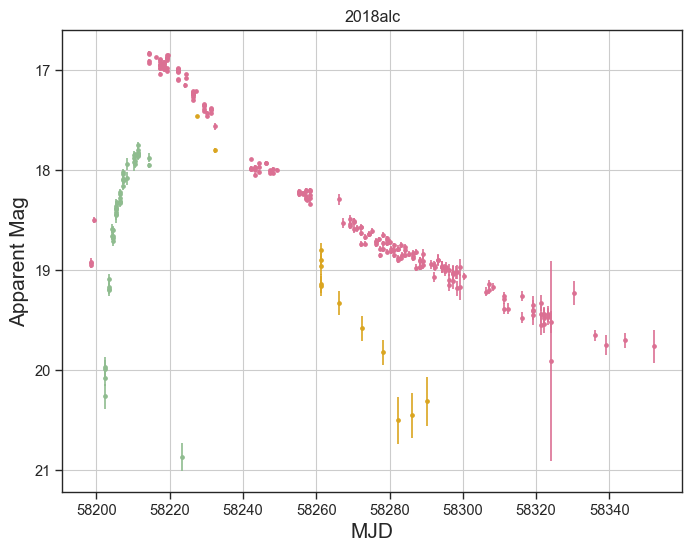

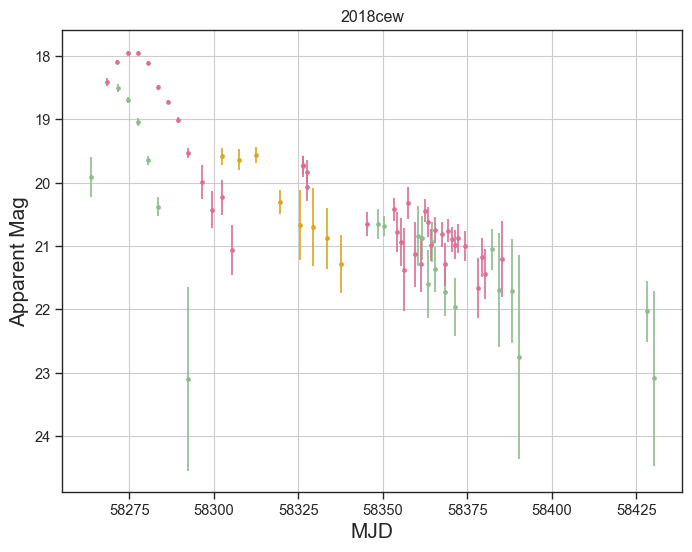

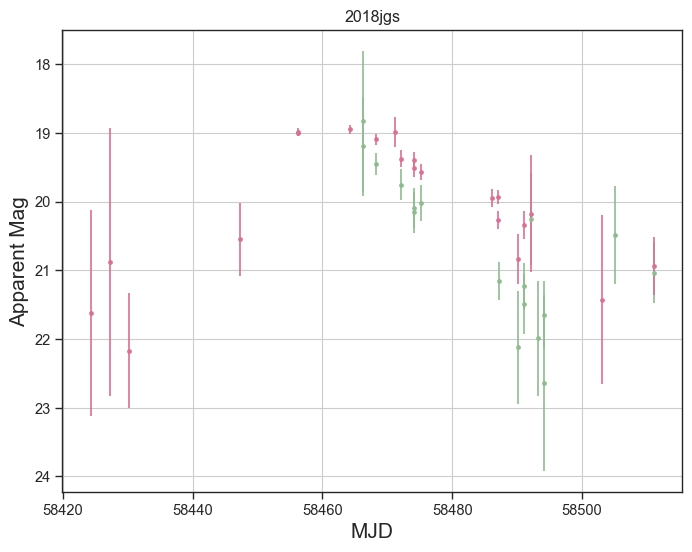

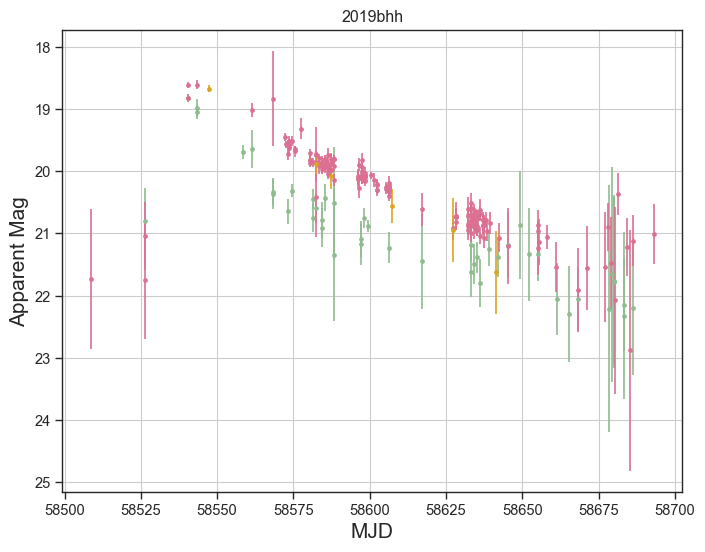

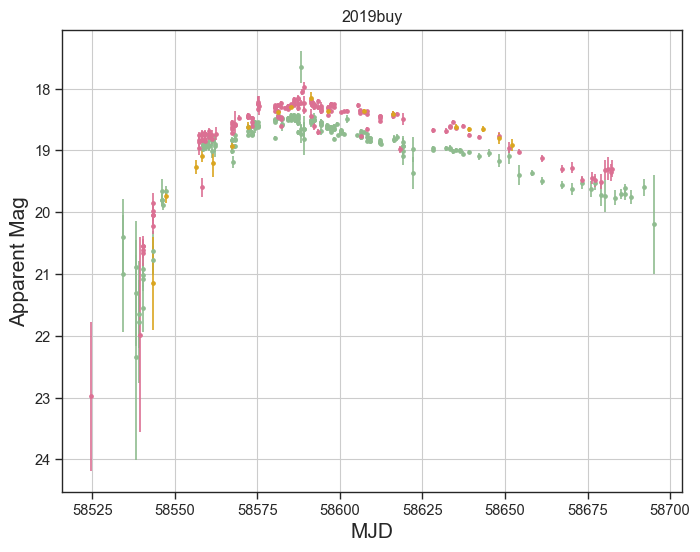

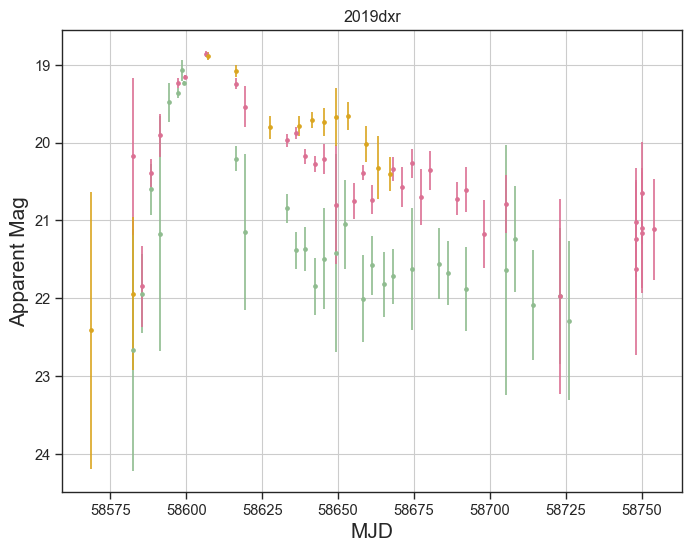

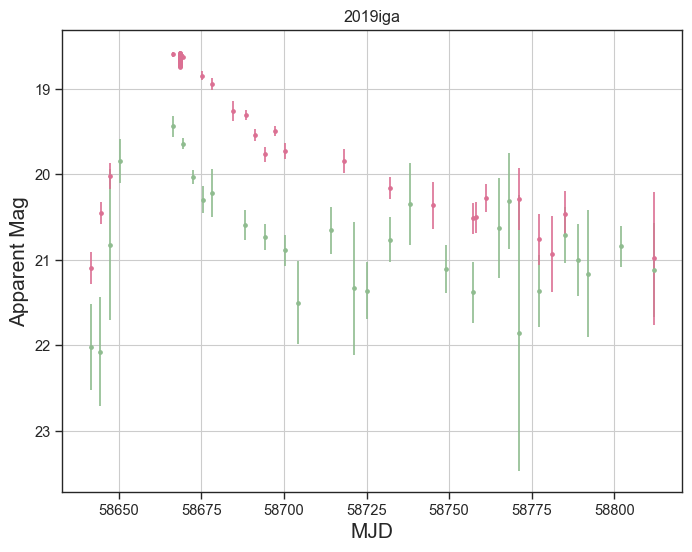

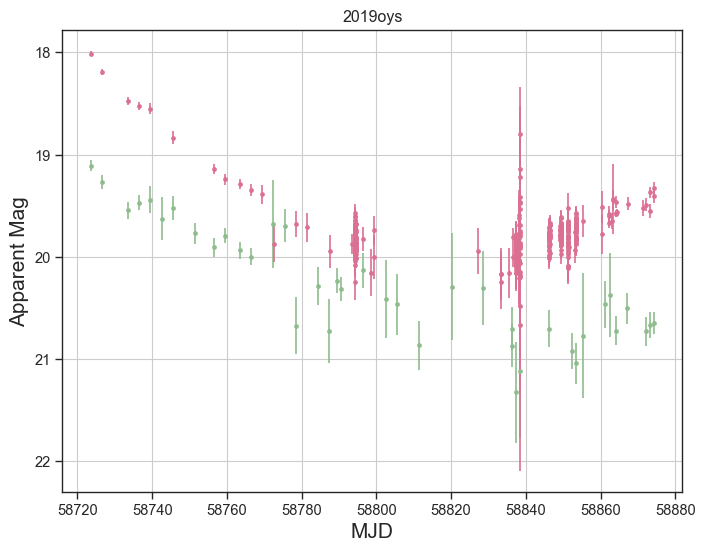

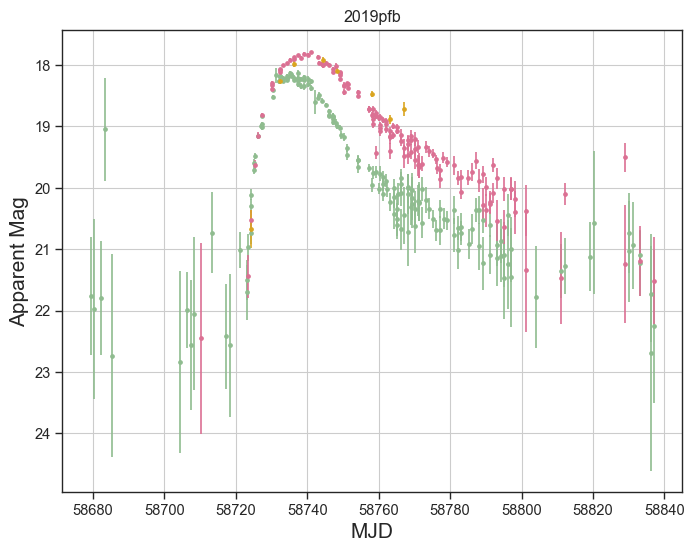

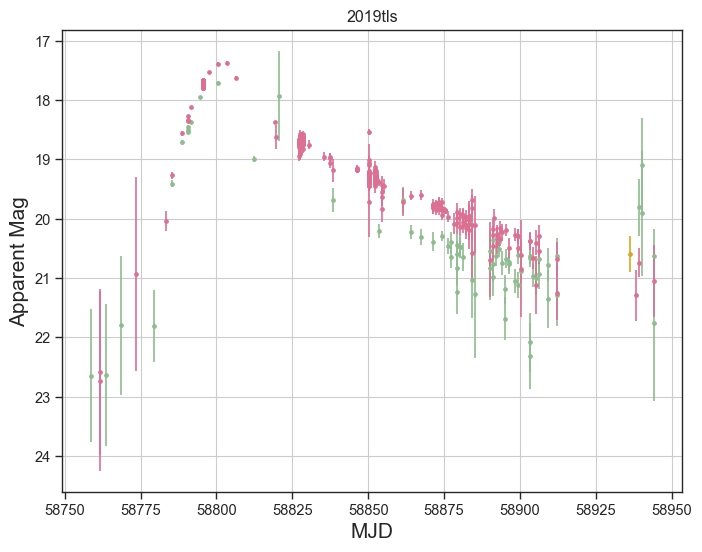

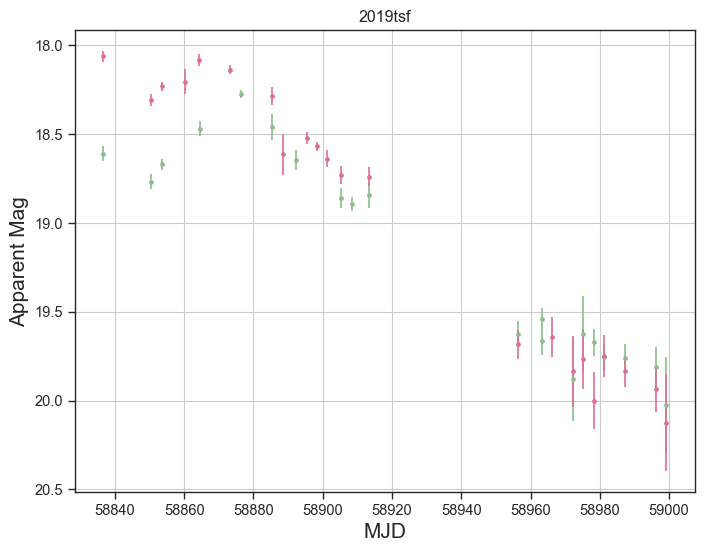

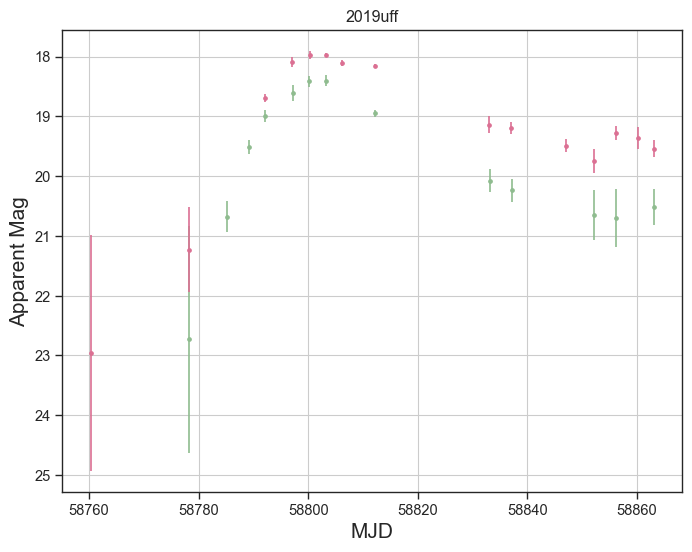

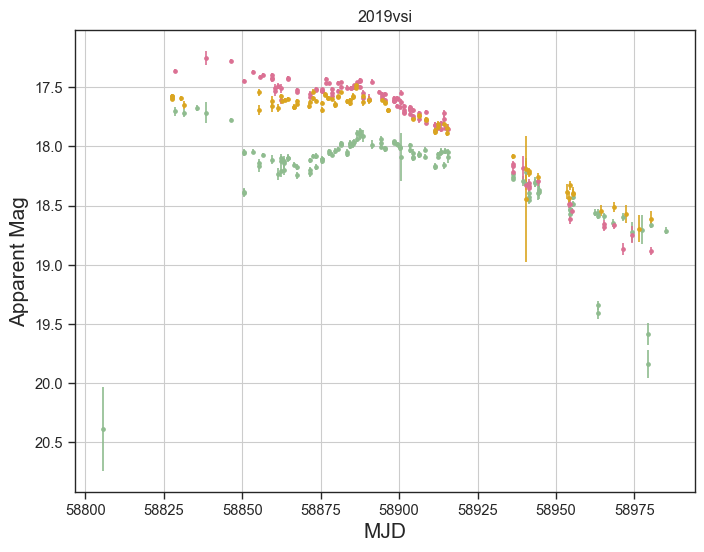

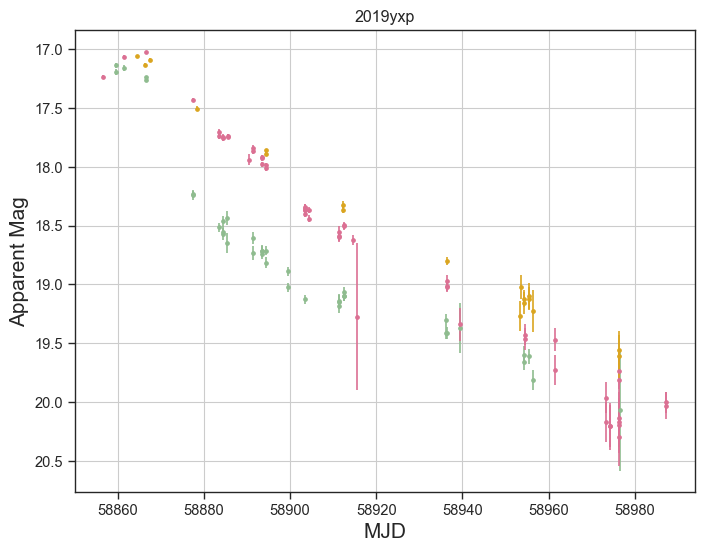

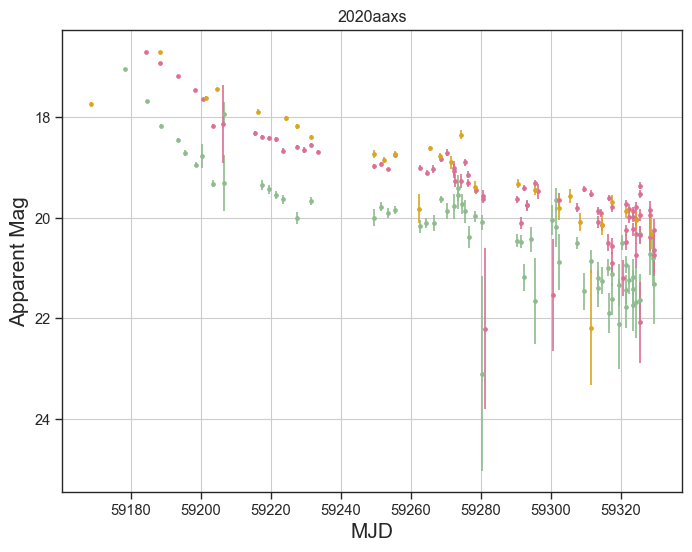

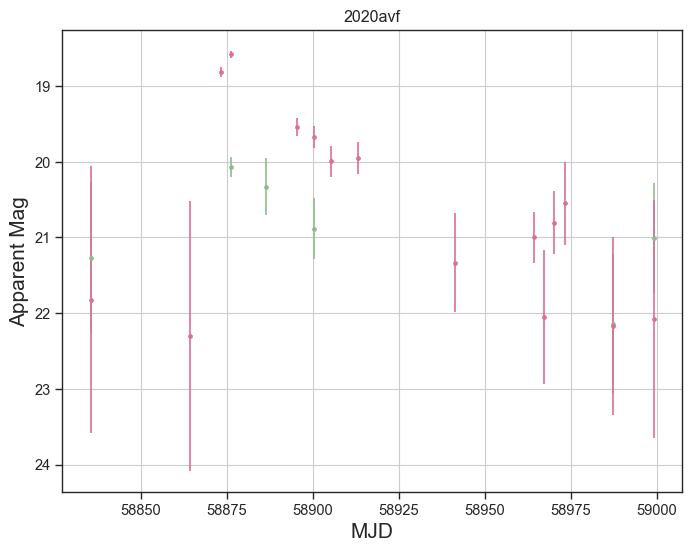

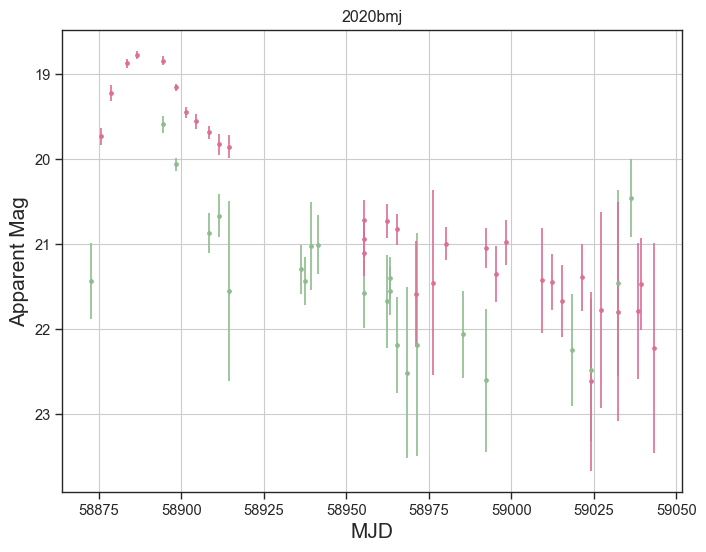

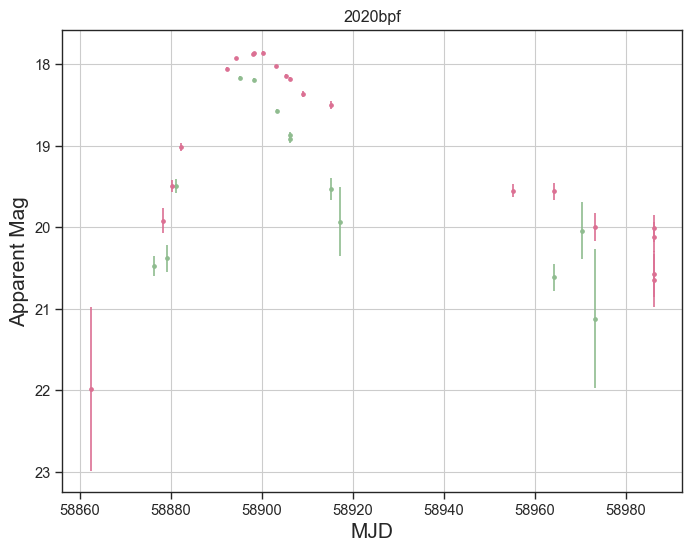

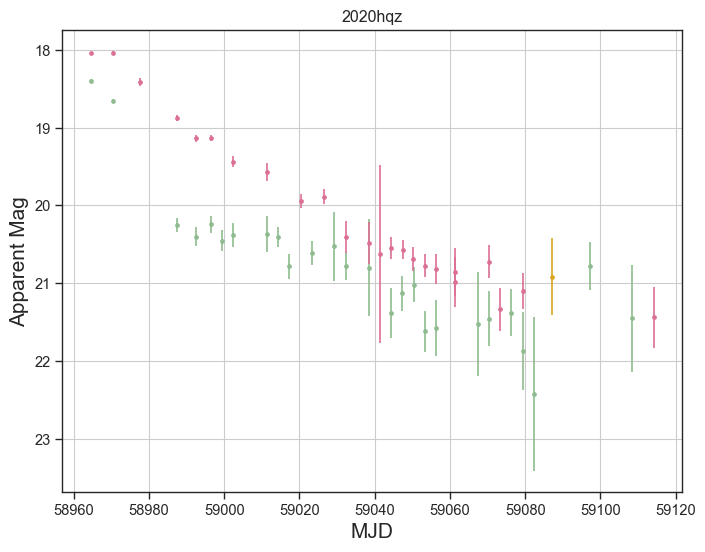

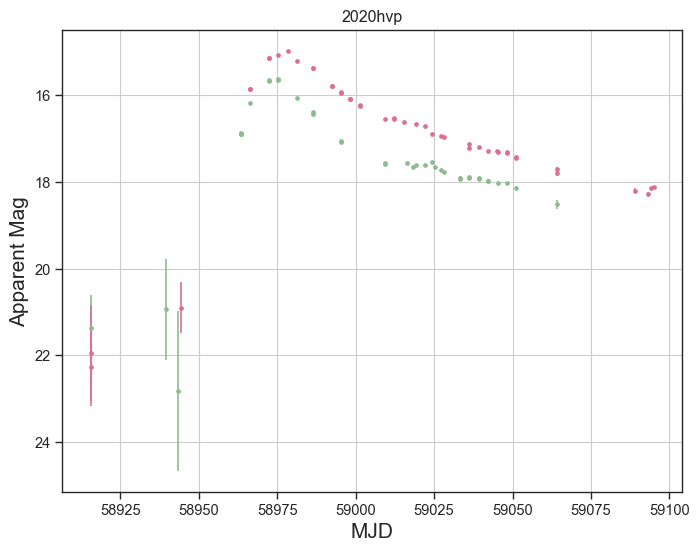

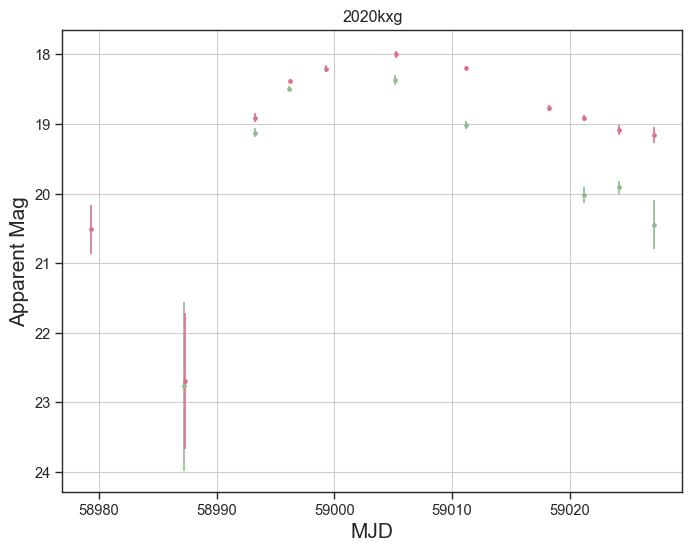

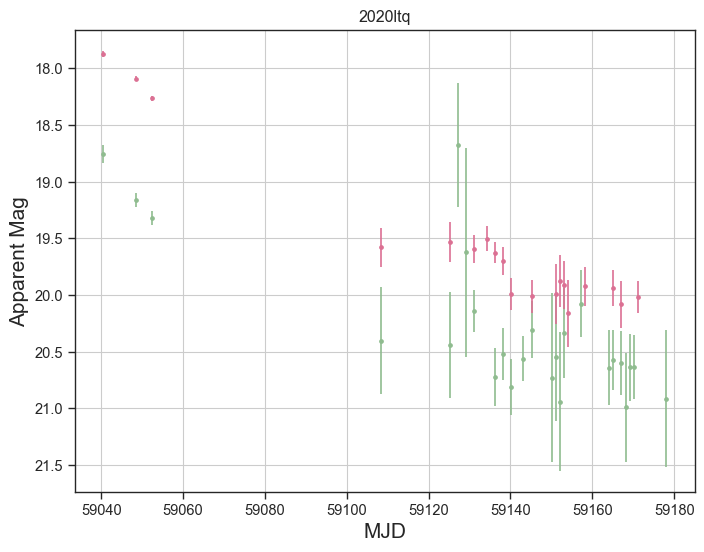

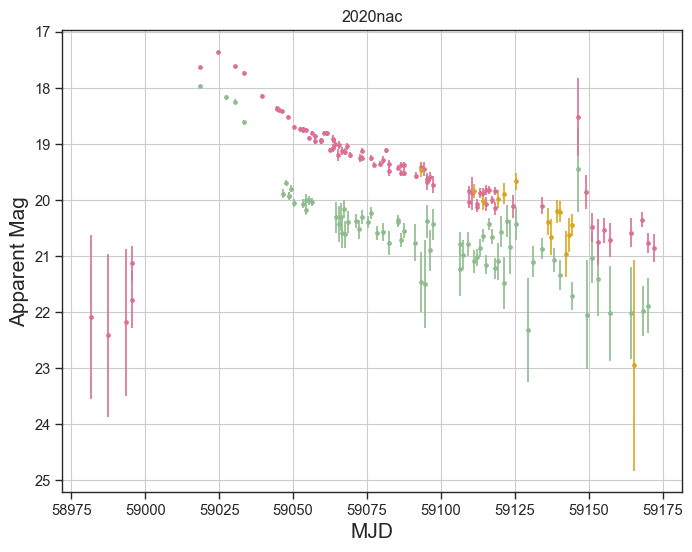

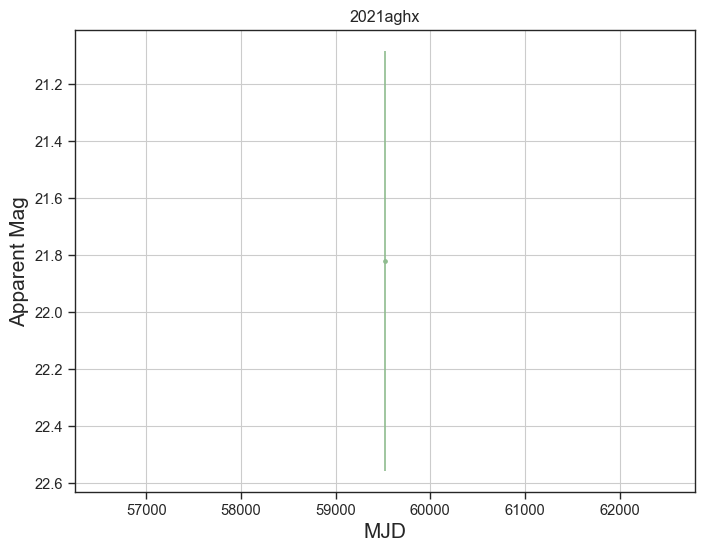

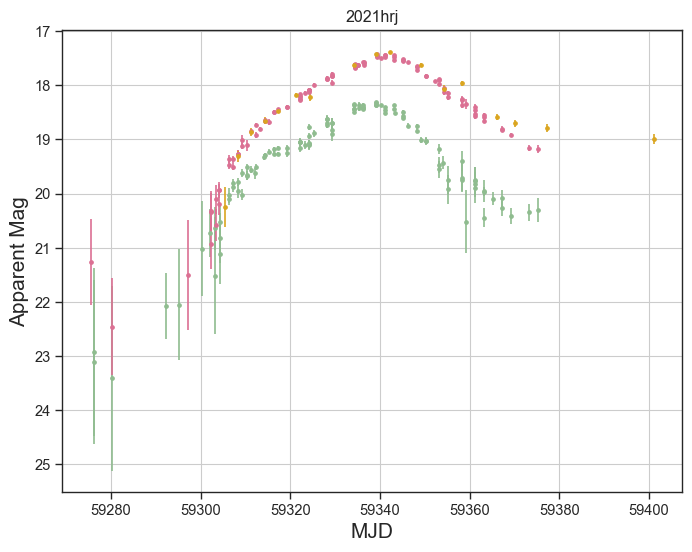

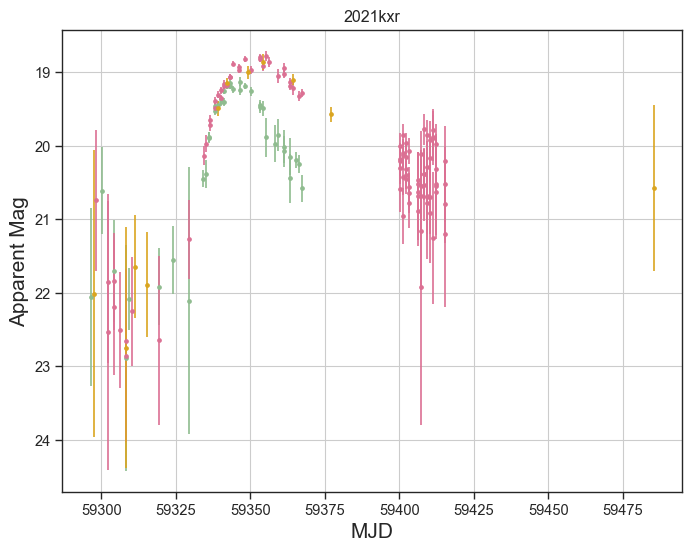

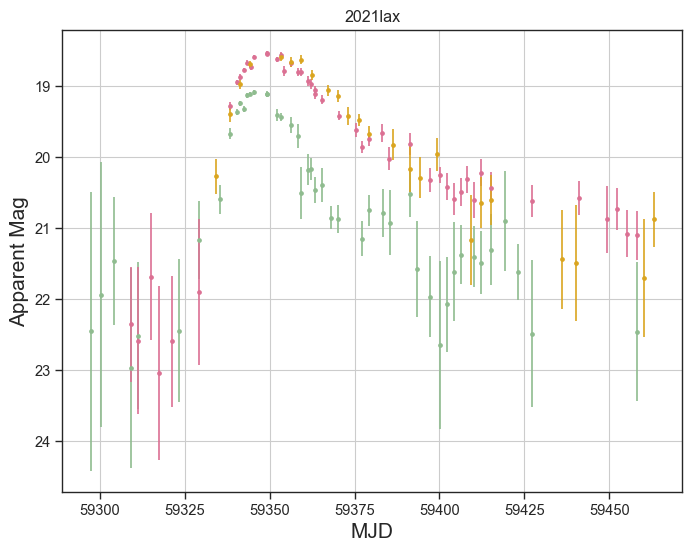

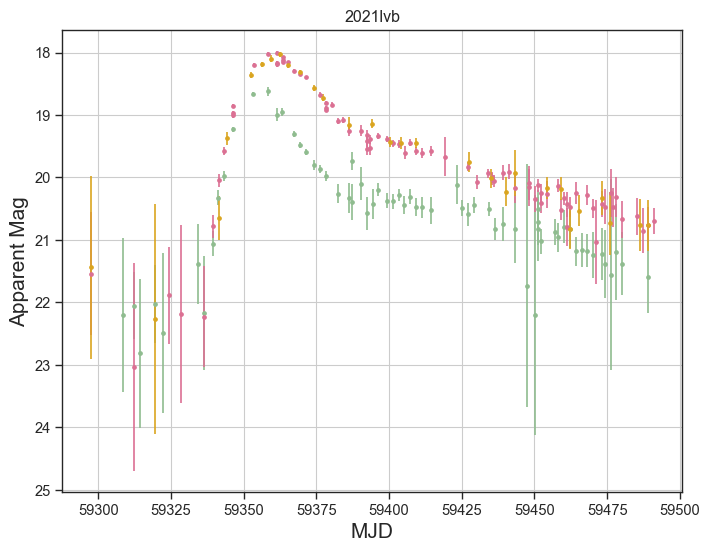

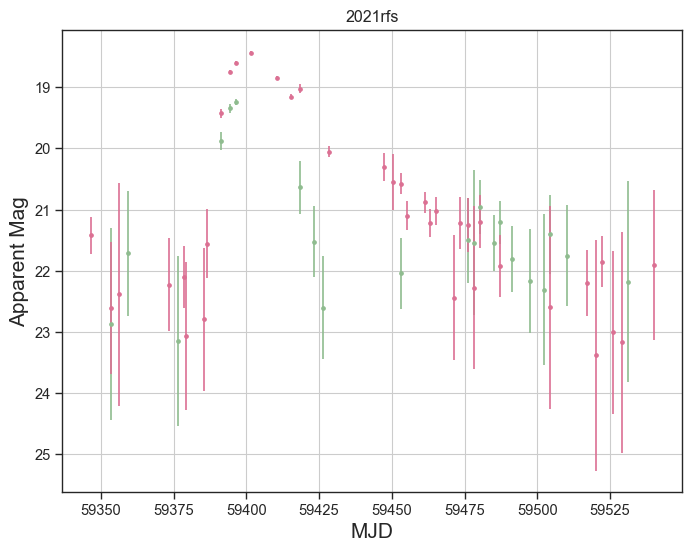

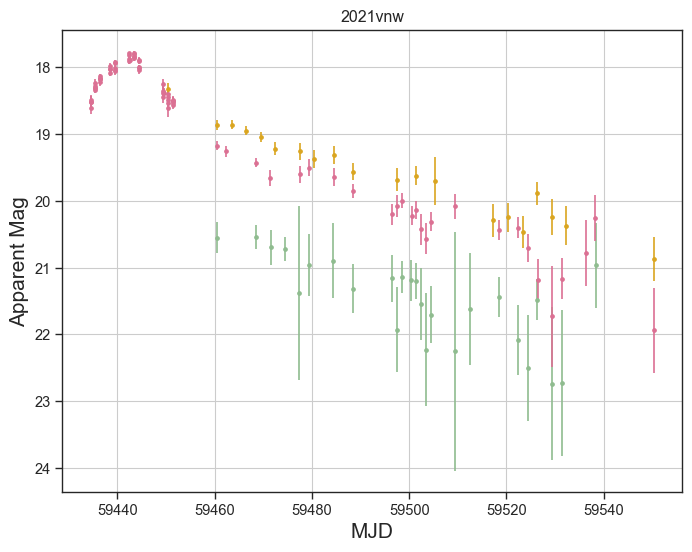

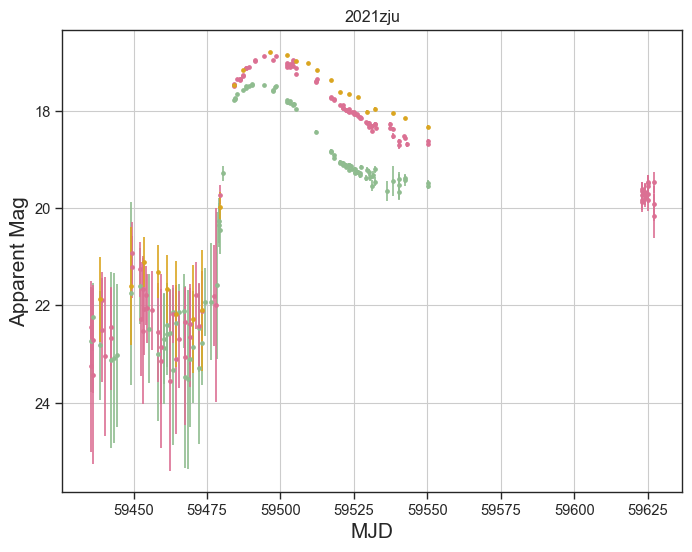

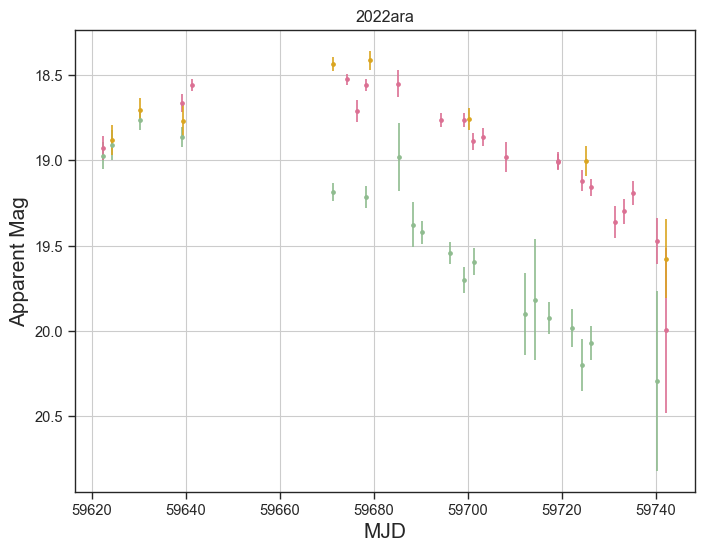

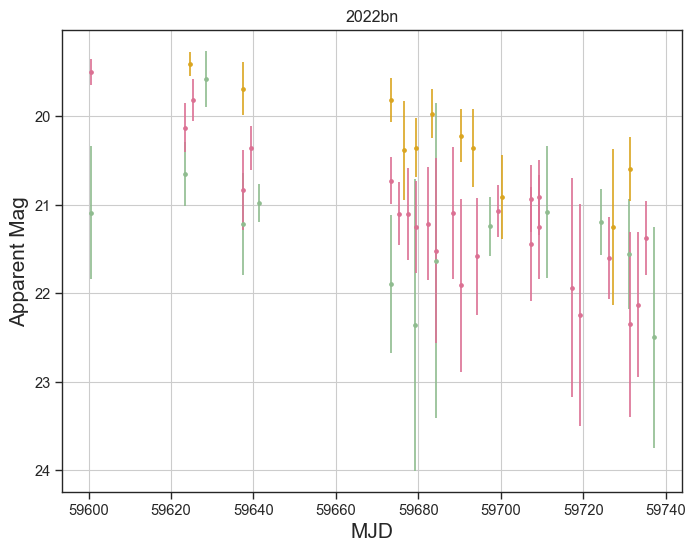

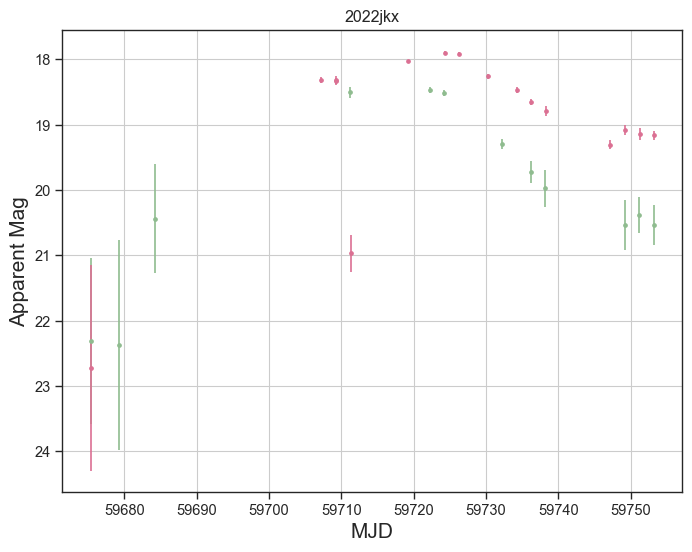

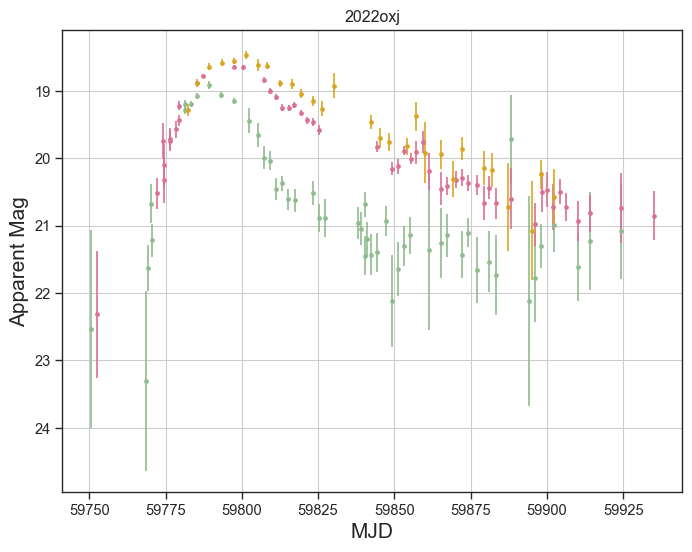

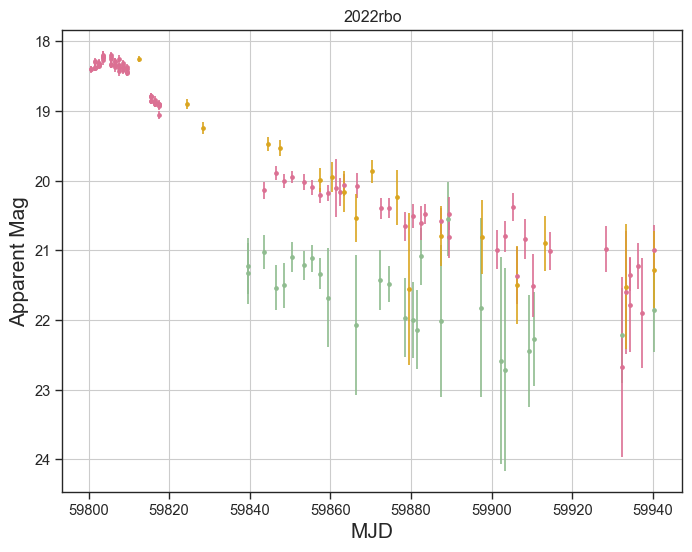

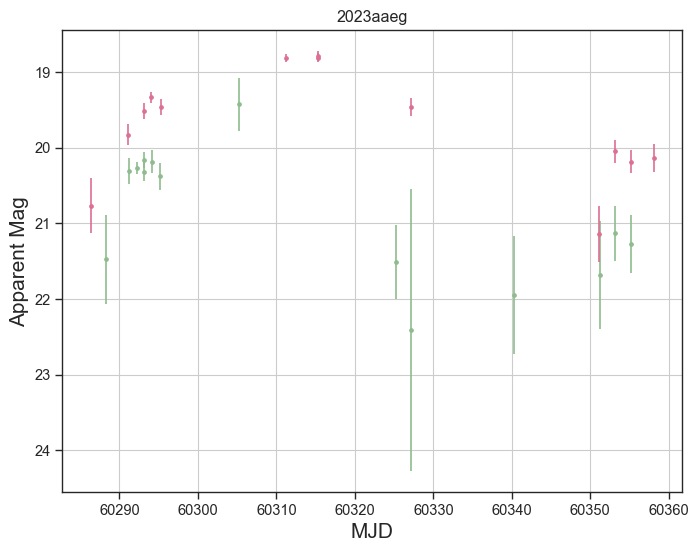

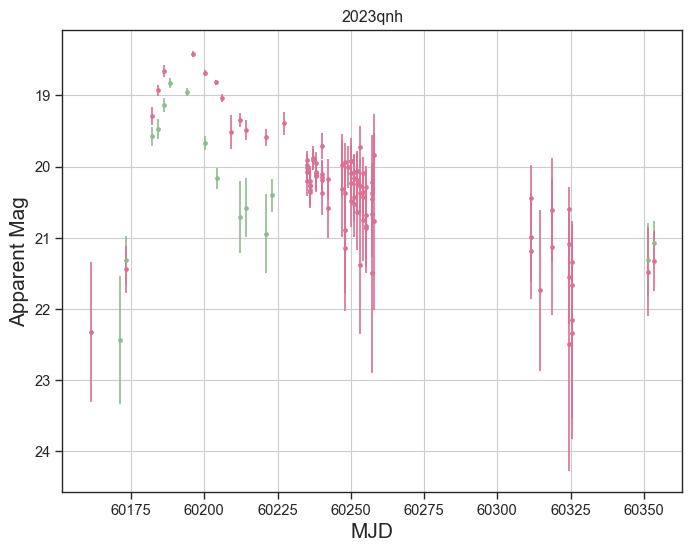

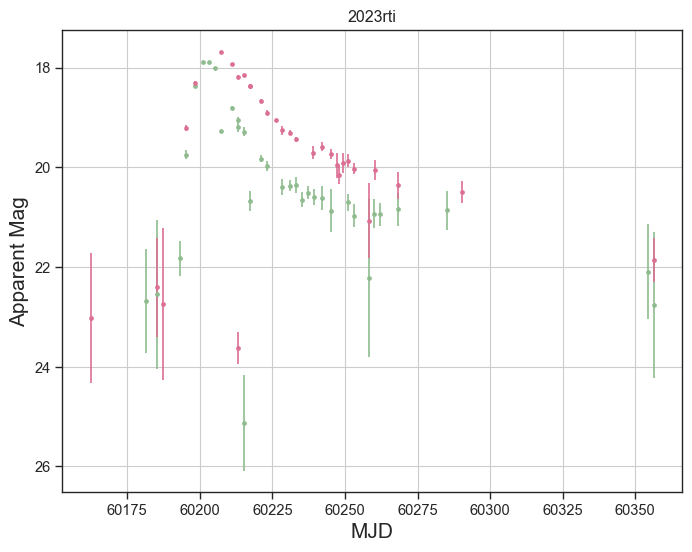

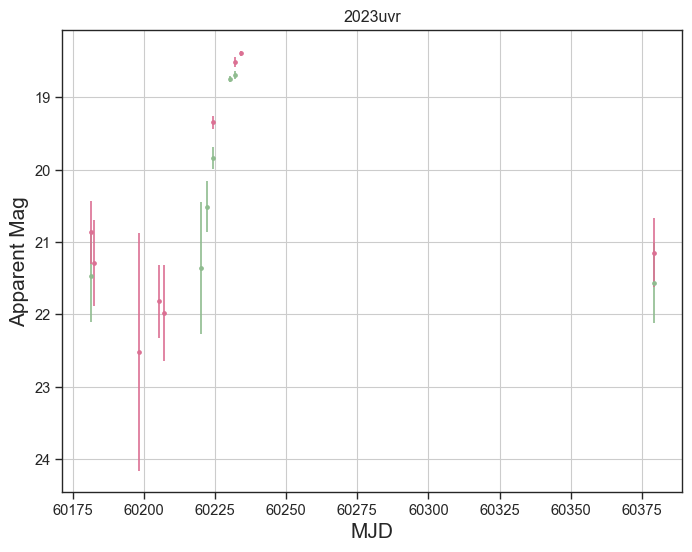

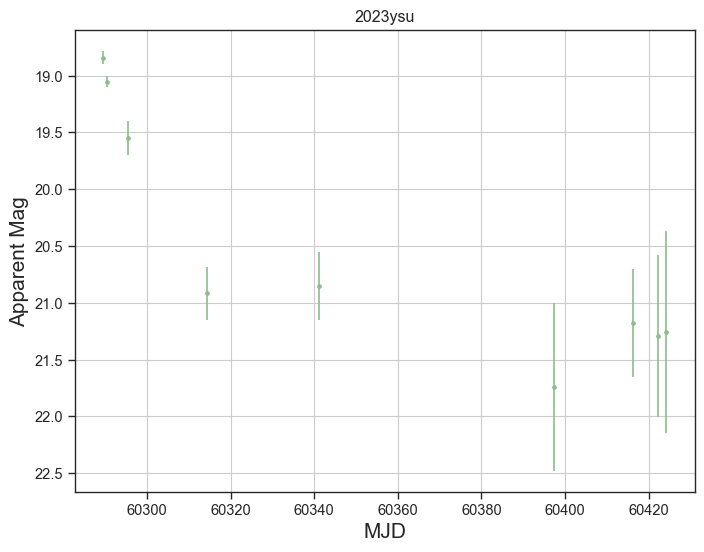

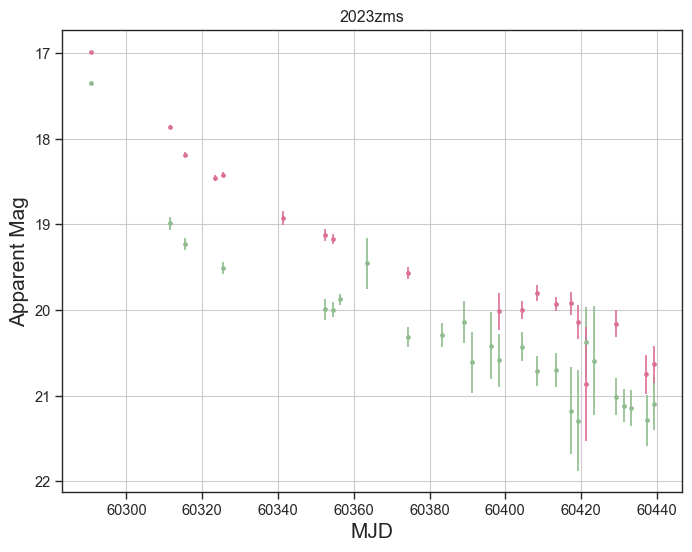

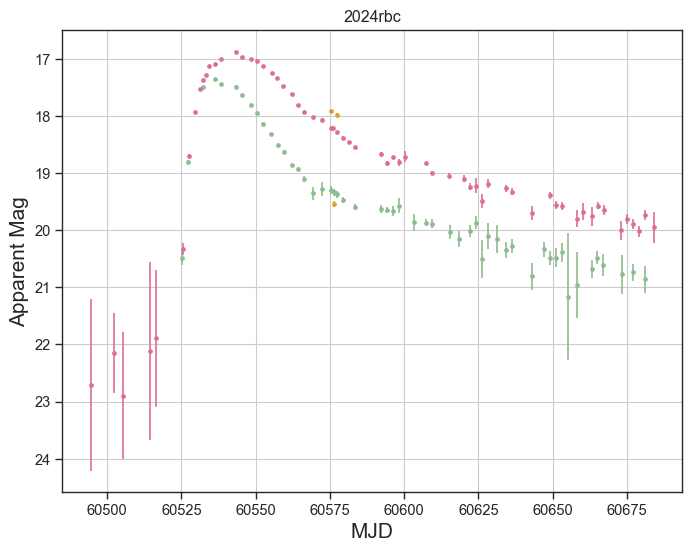

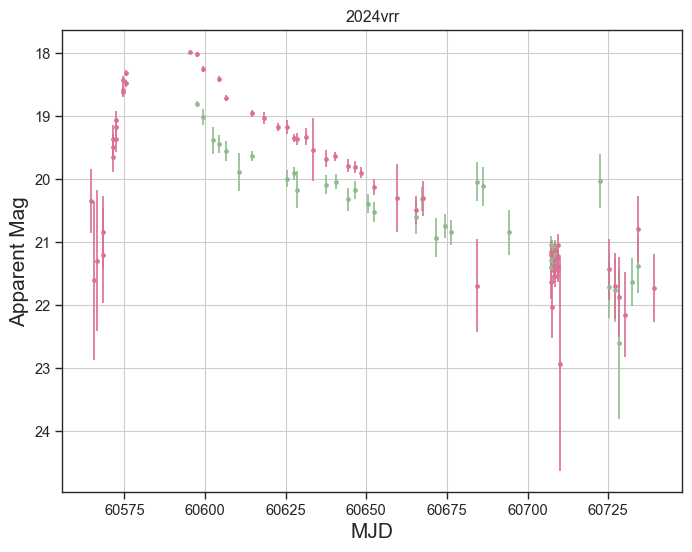

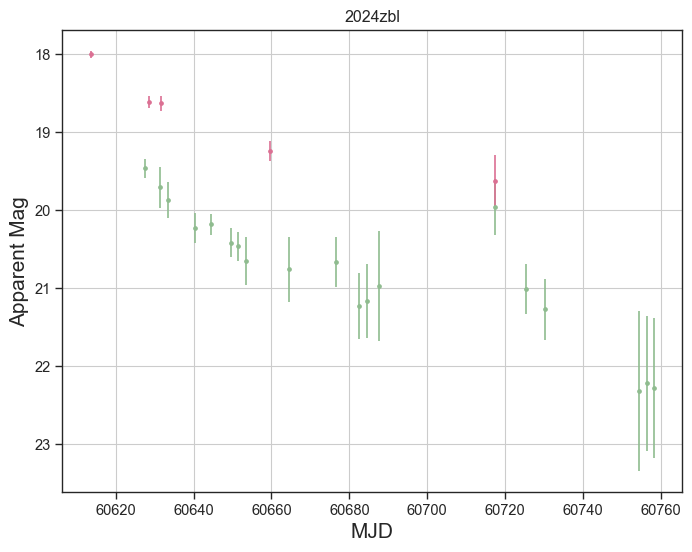

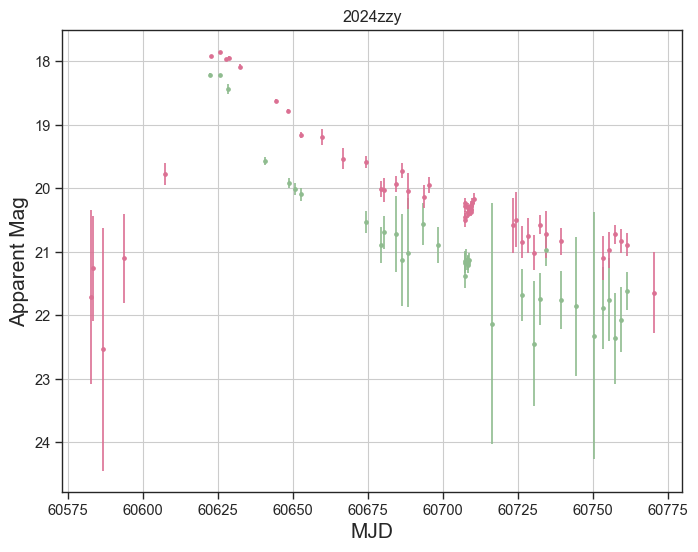

In [ ]:
# plot_all_ztf_lcs(lc_dfs_ib,sn_names_ib,save=True)

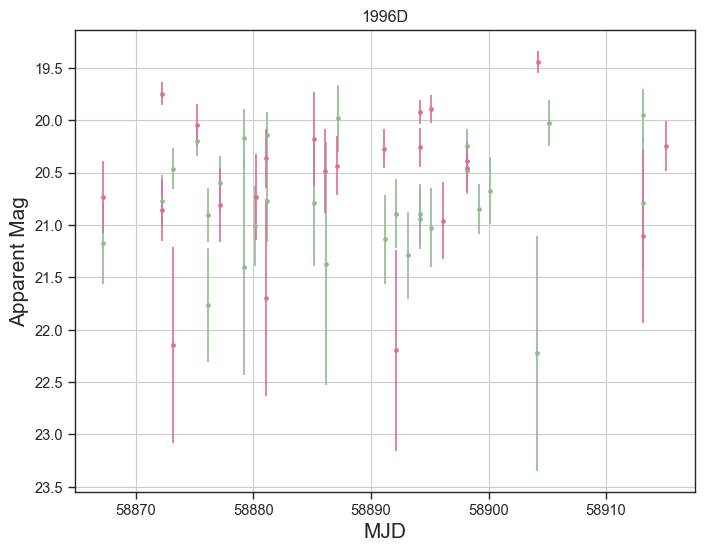

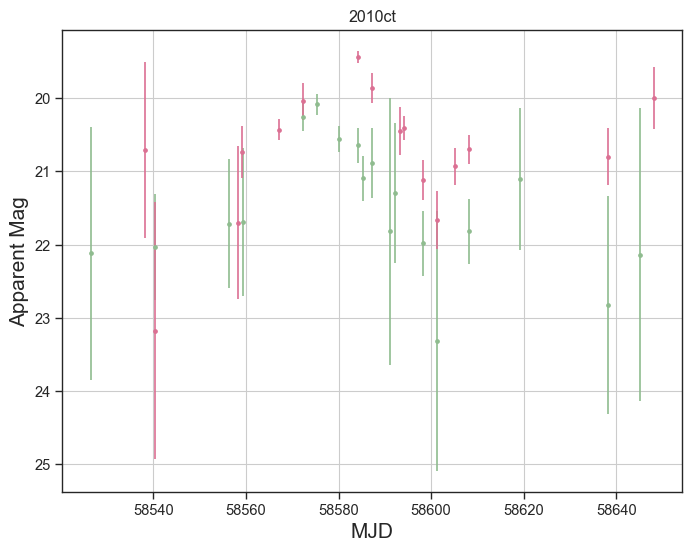

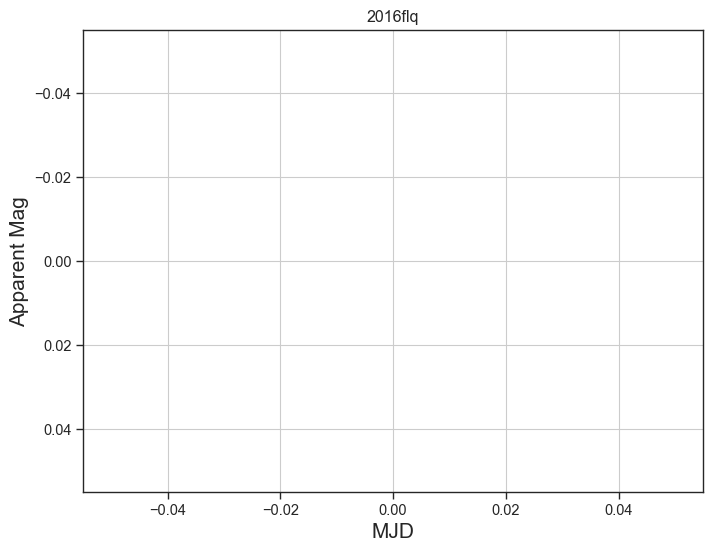

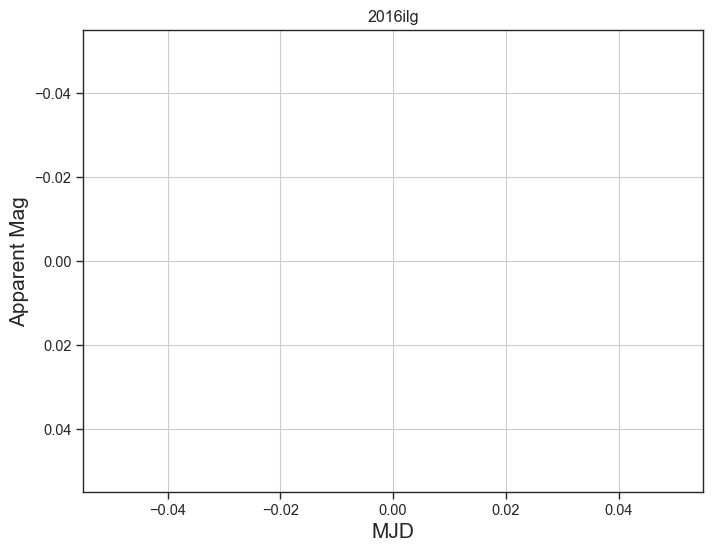

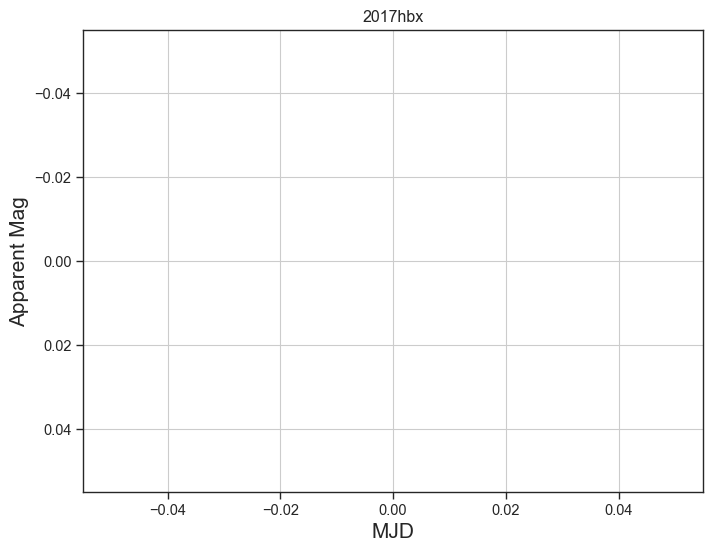

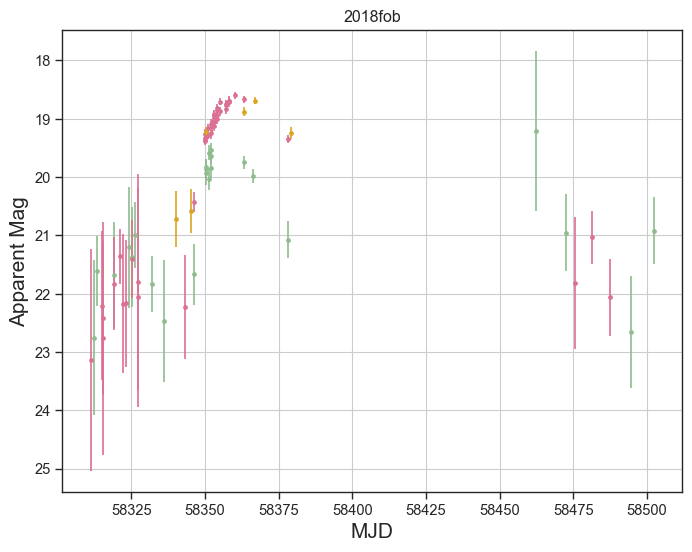

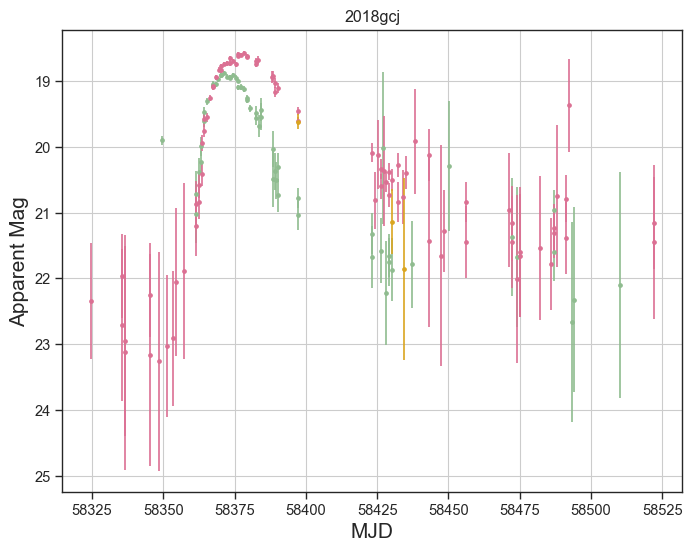

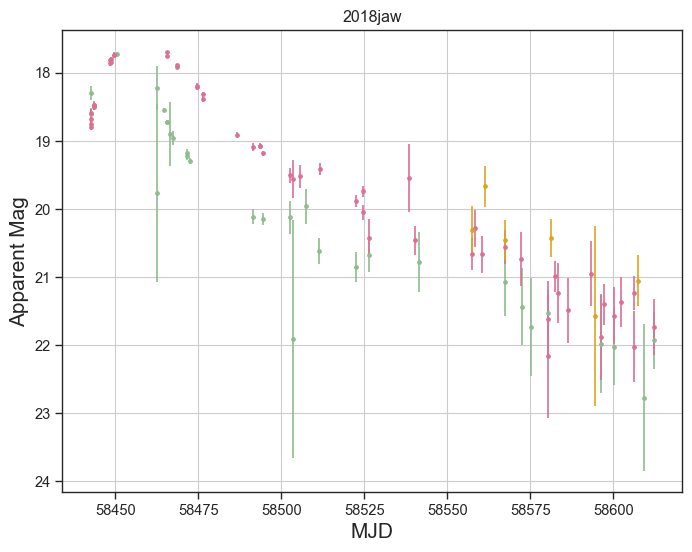

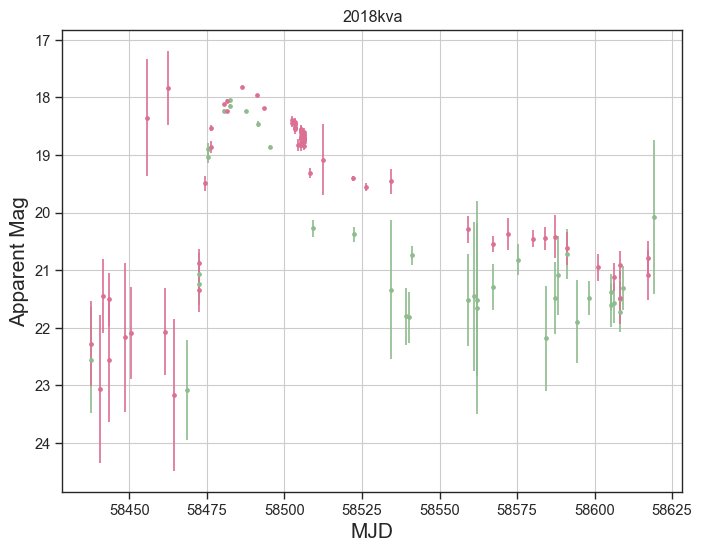

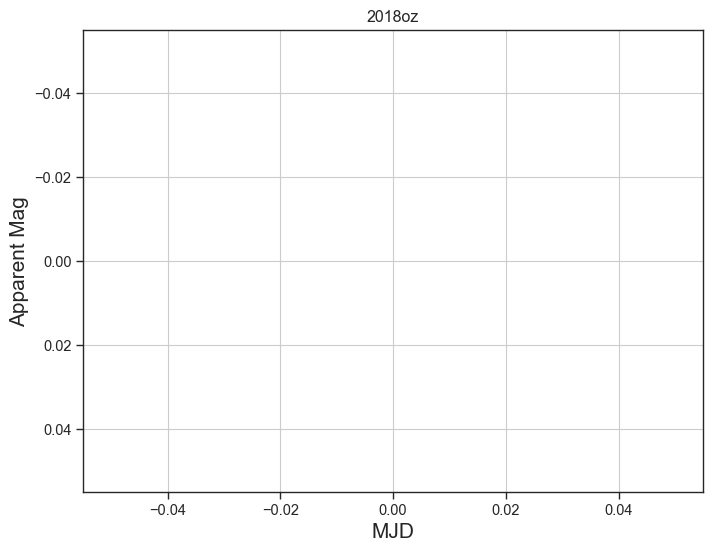

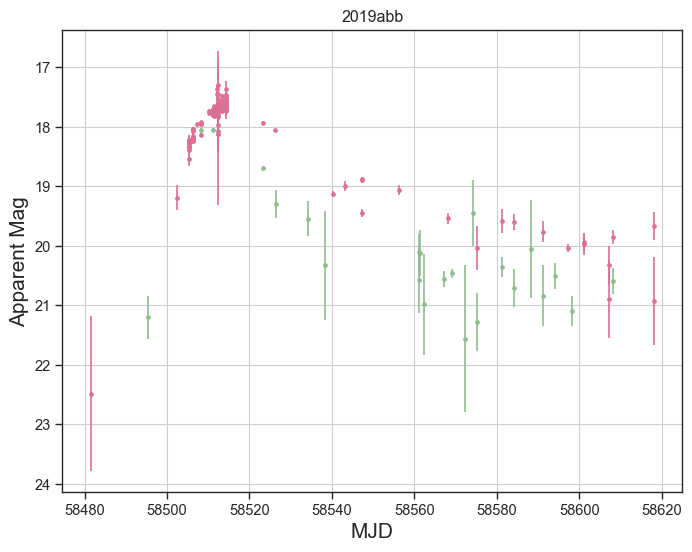

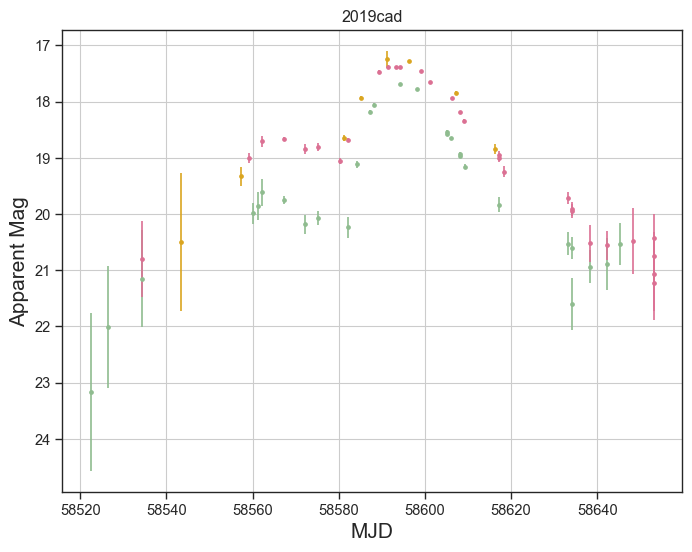

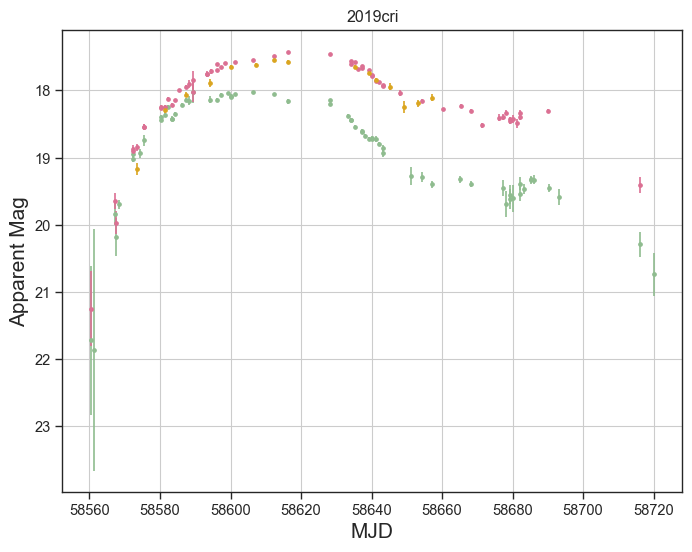

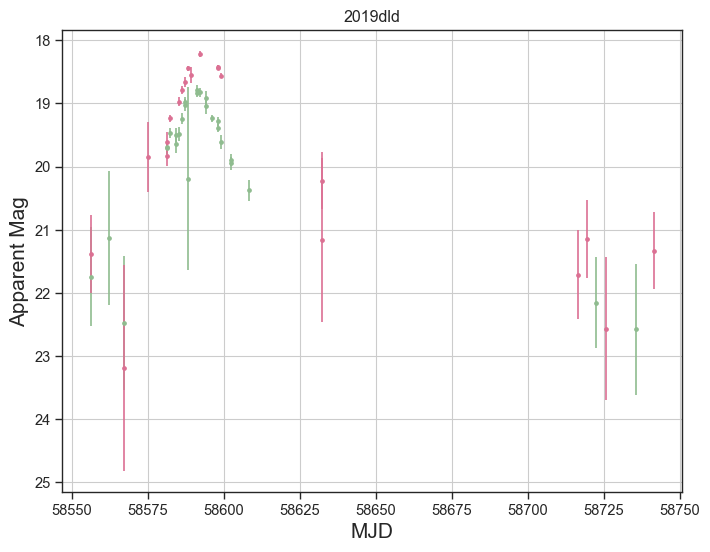

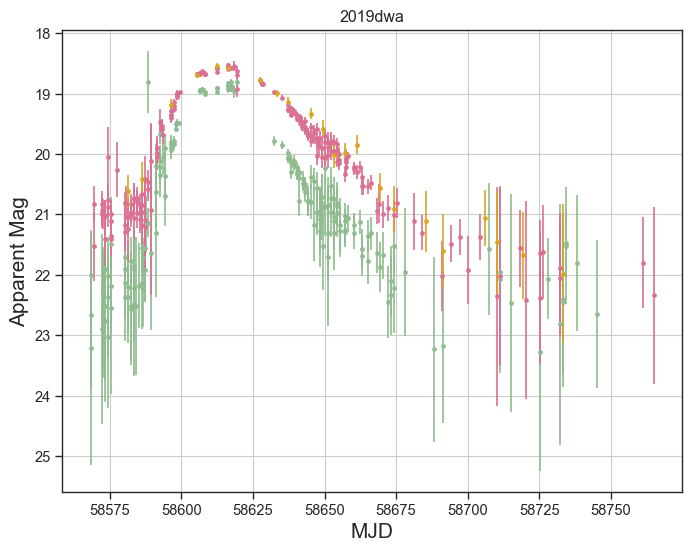

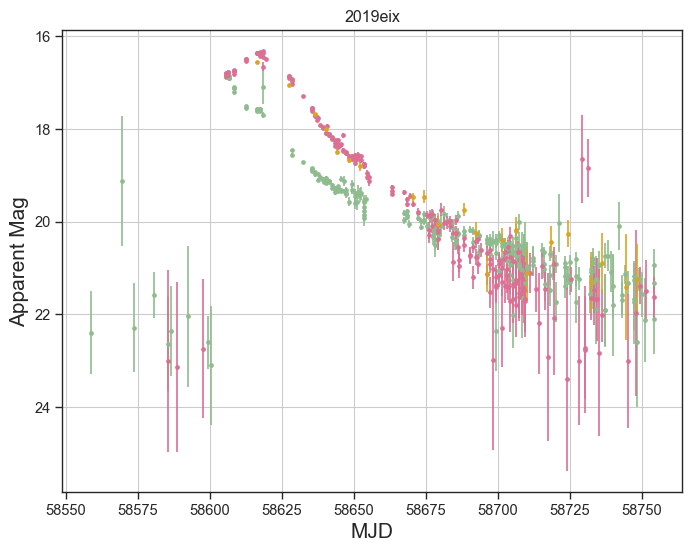

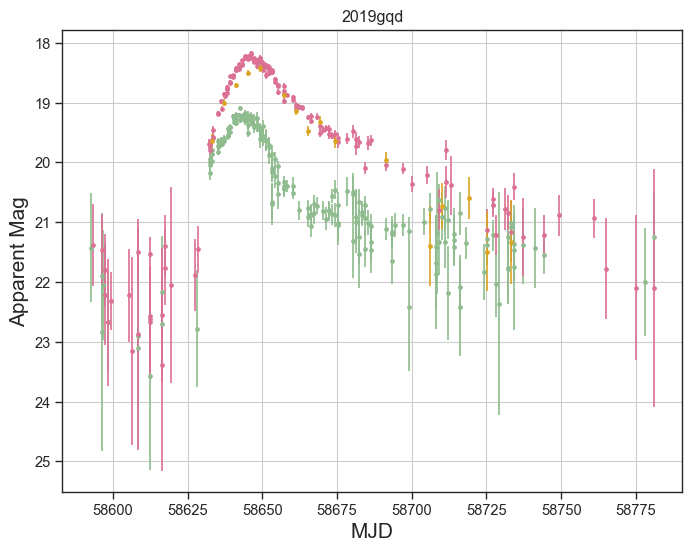

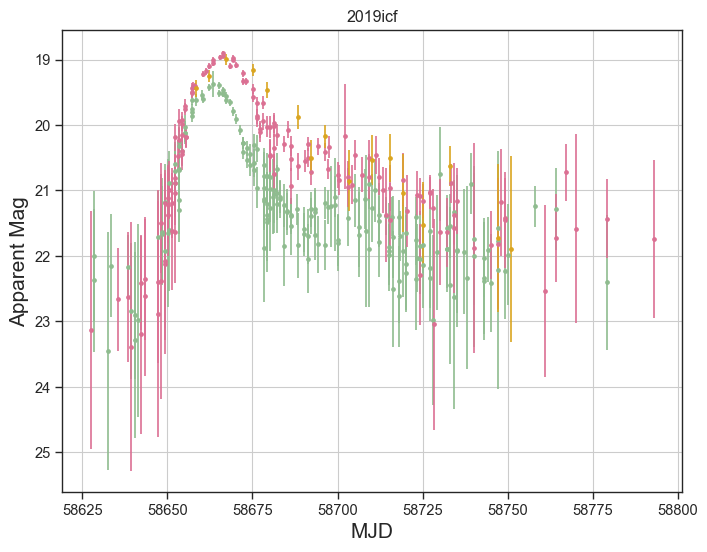

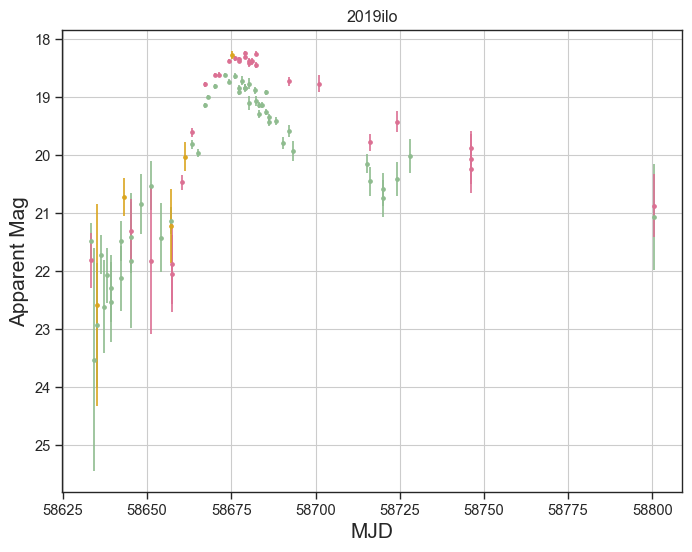

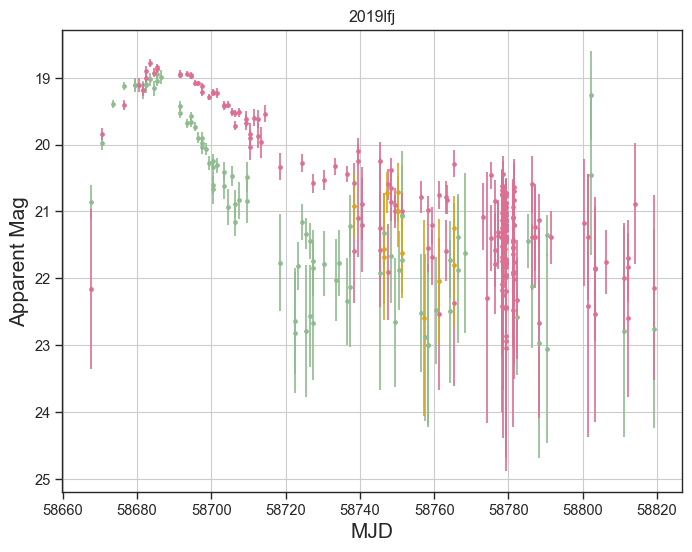

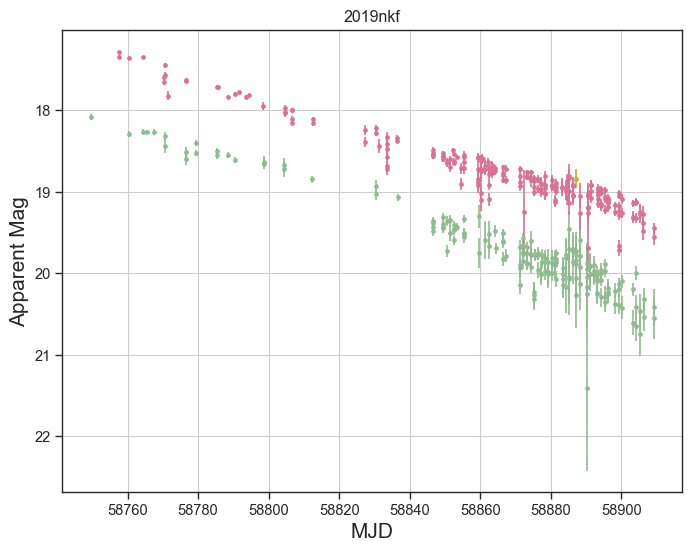

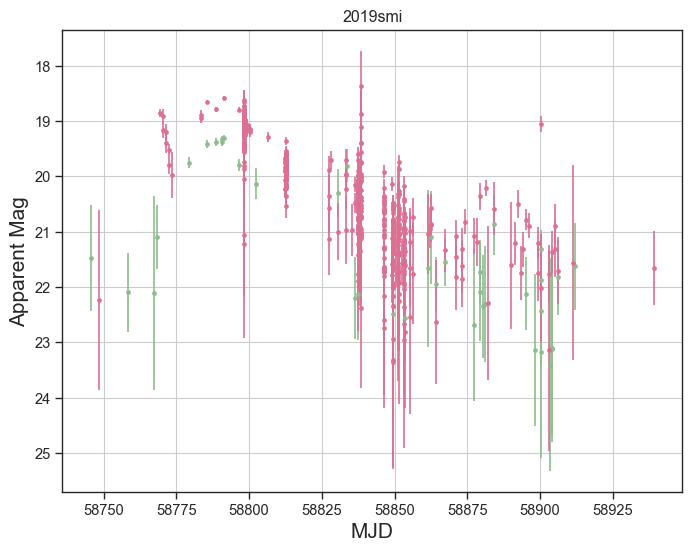

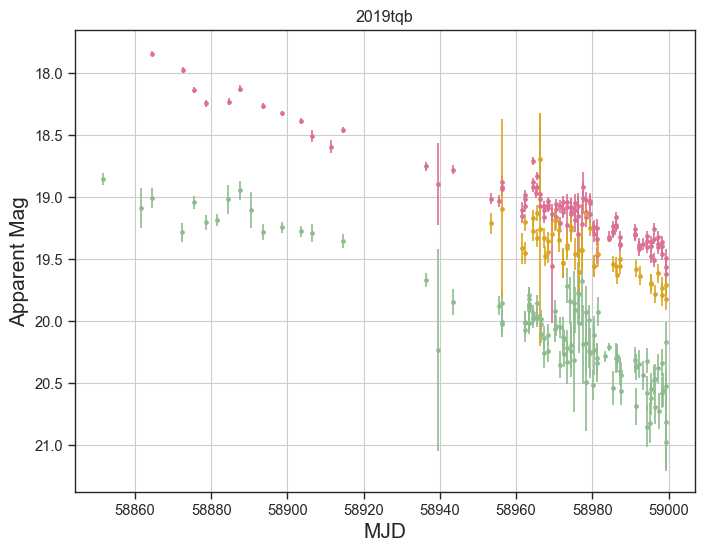

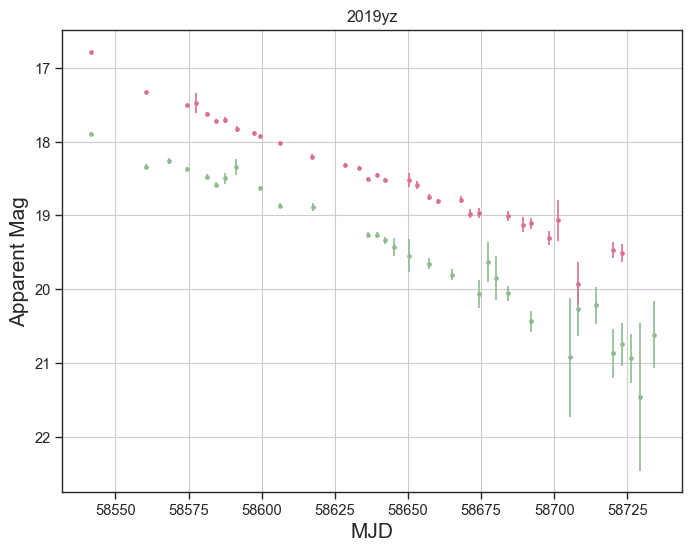

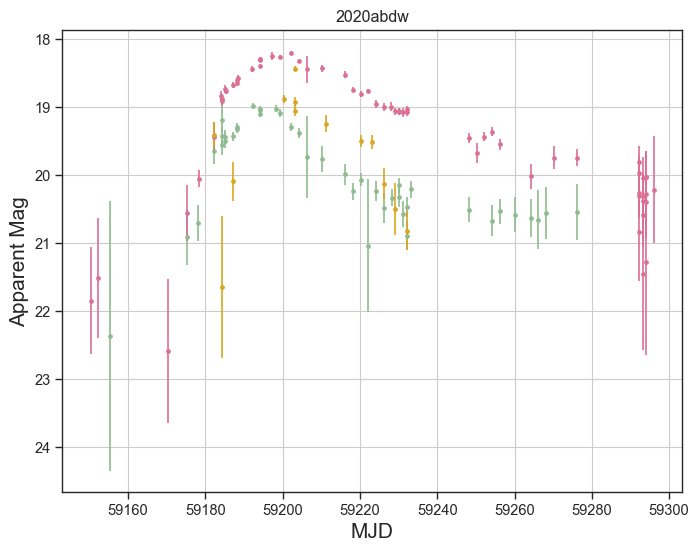

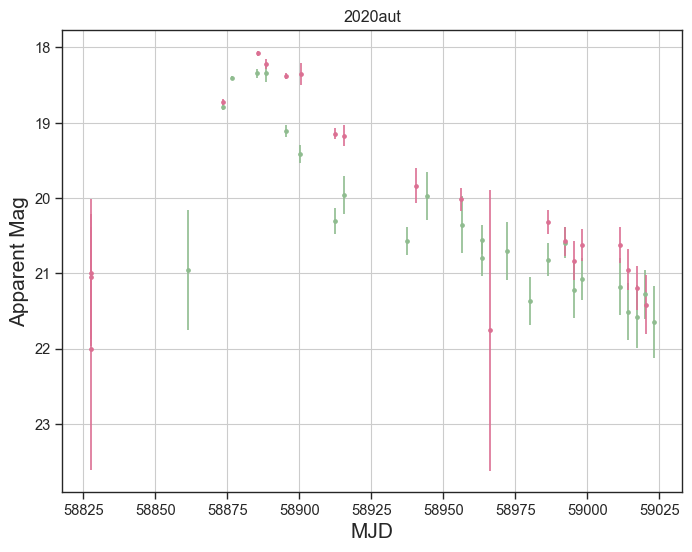

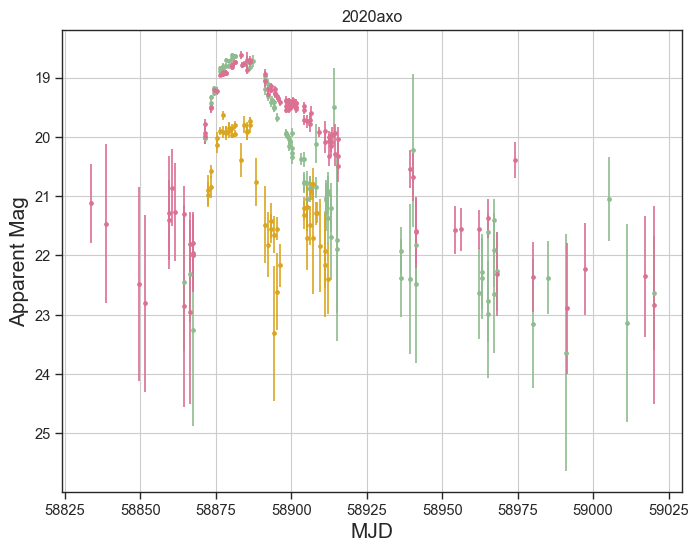

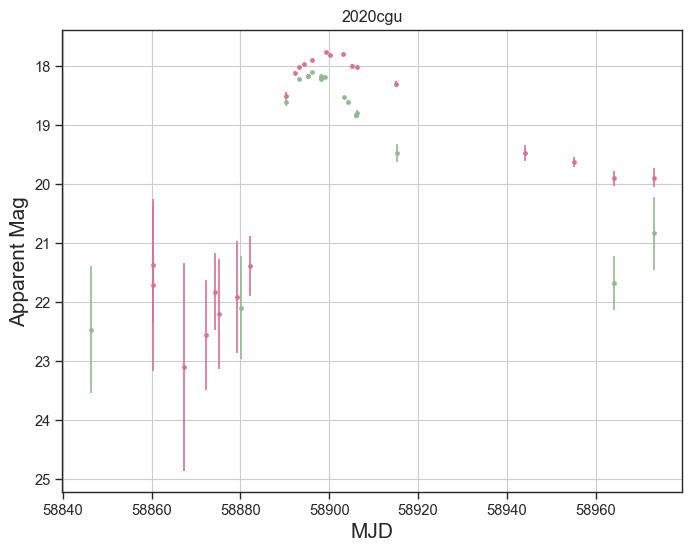

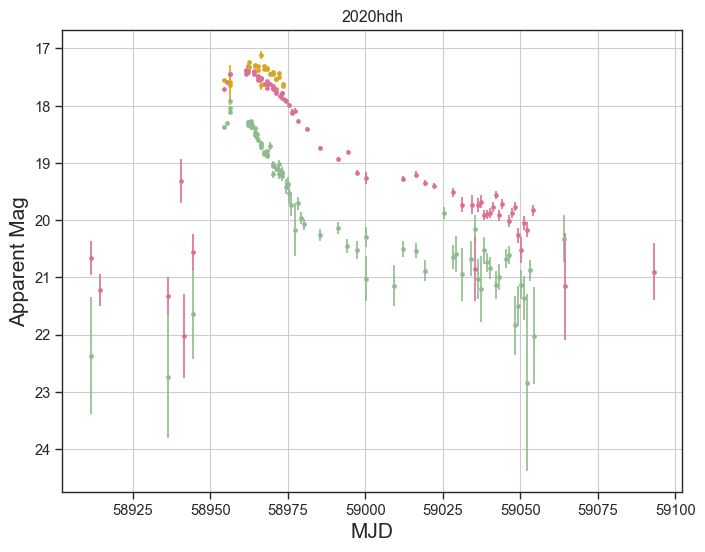

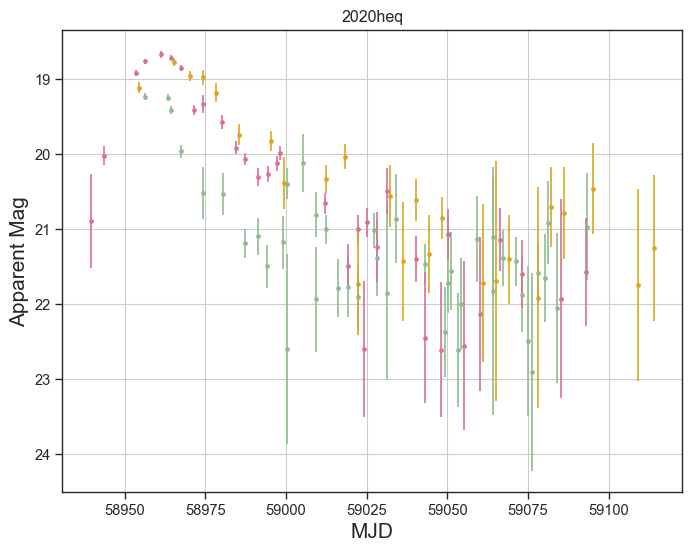

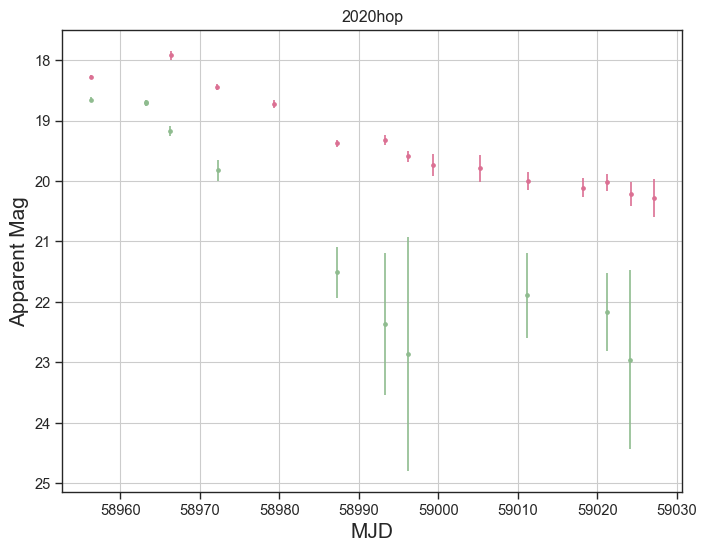

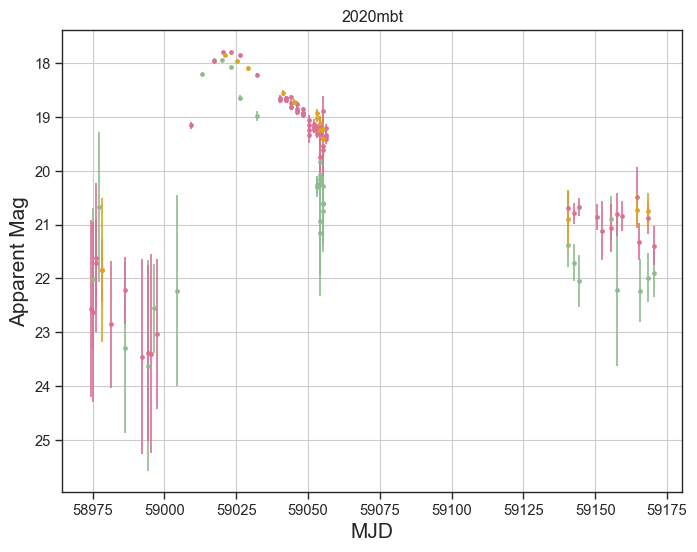

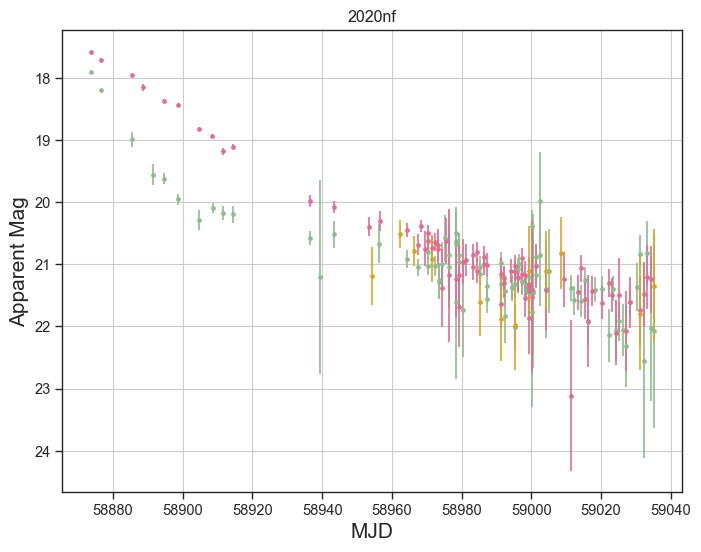

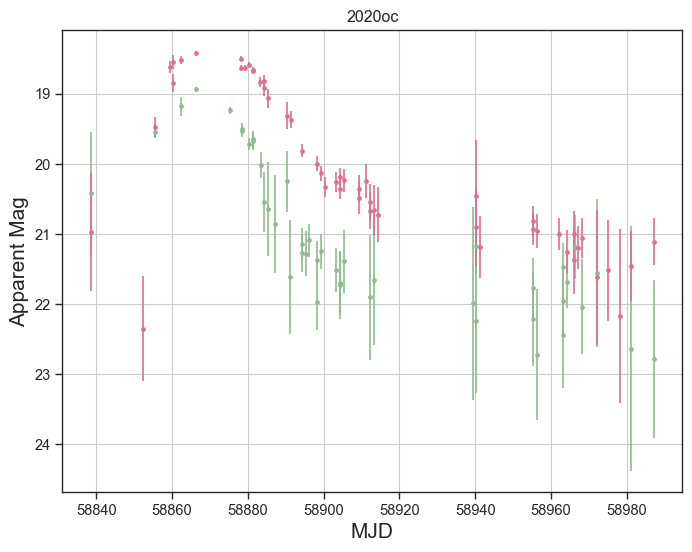

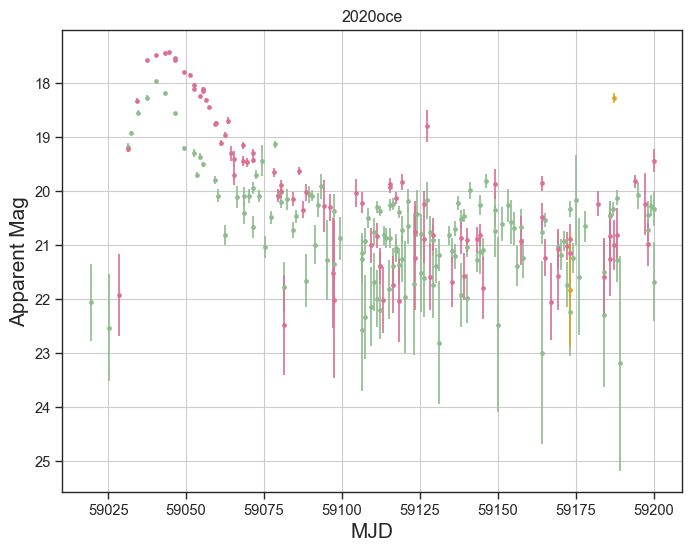

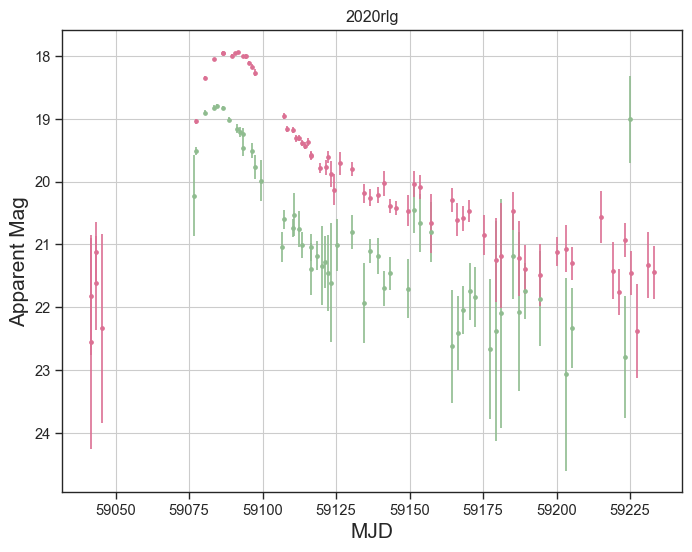

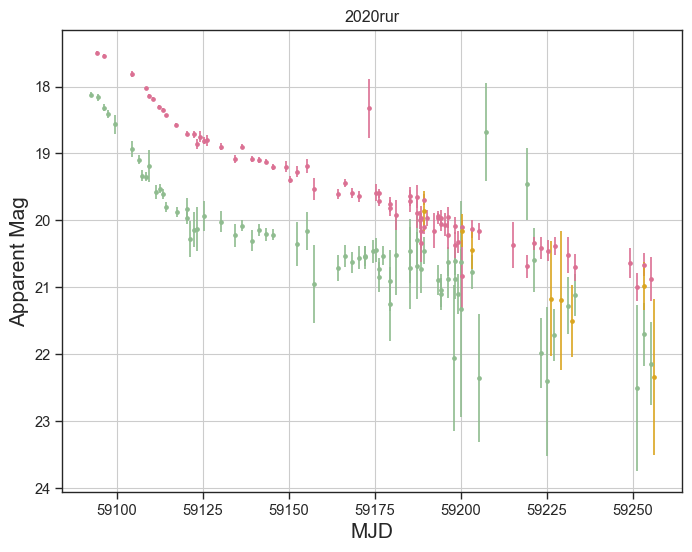

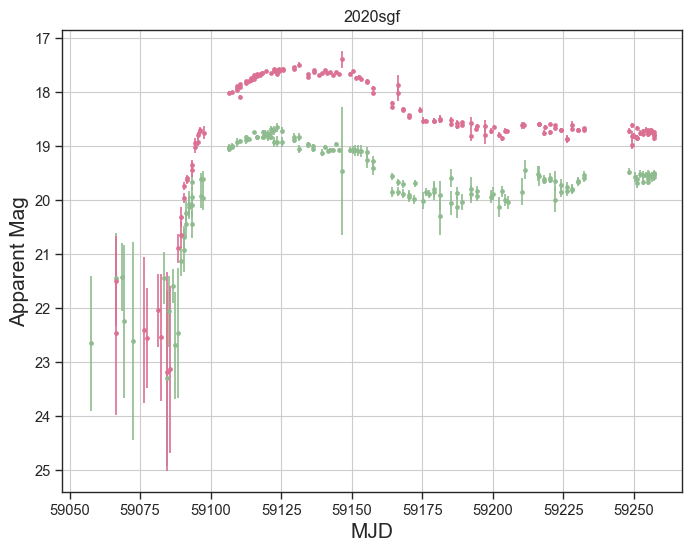

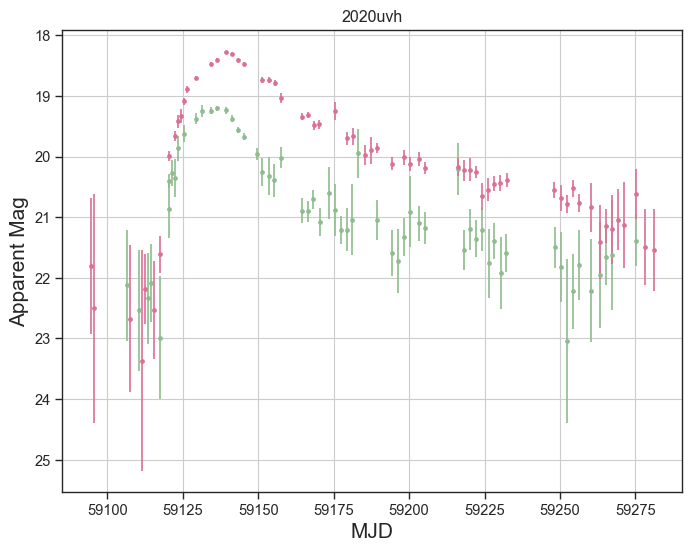

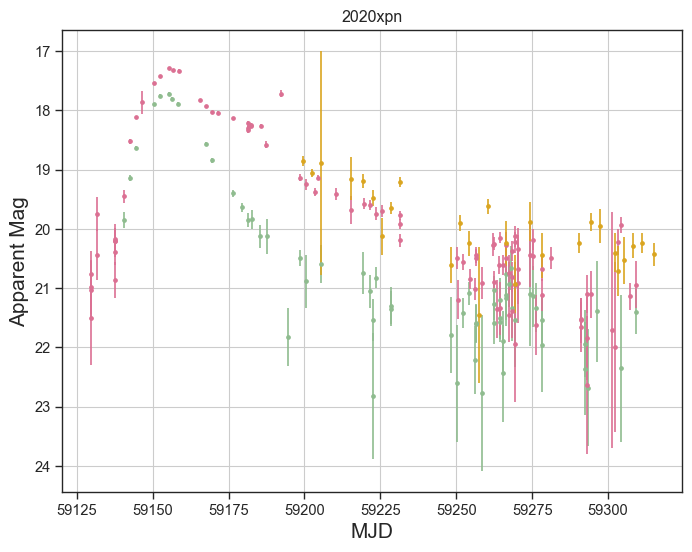

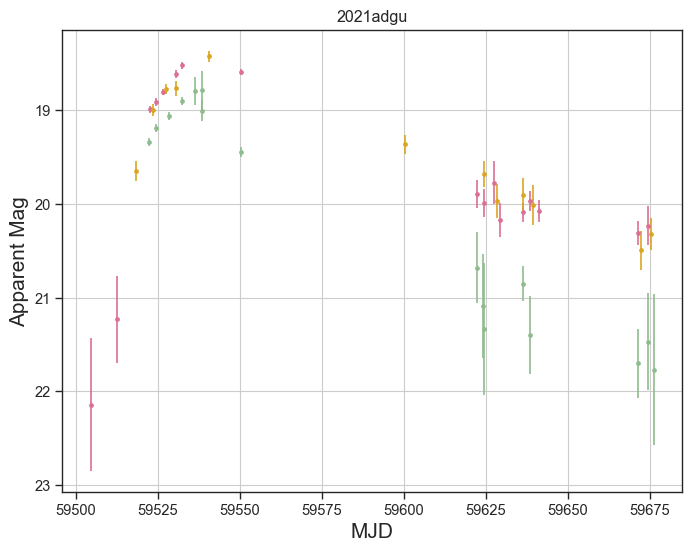

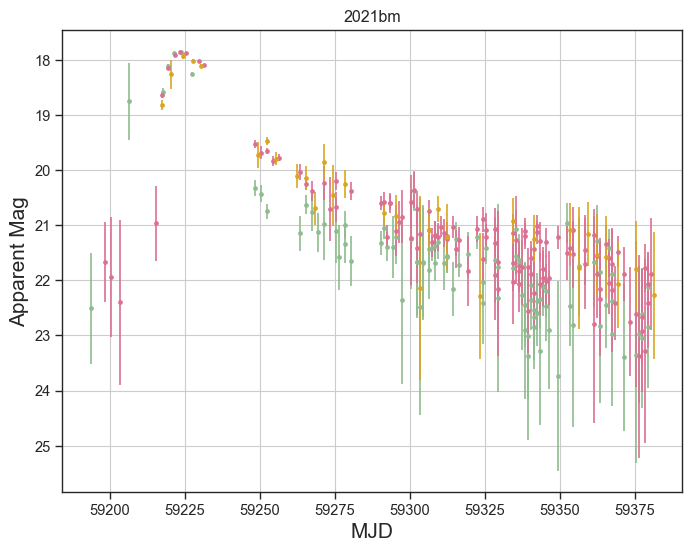

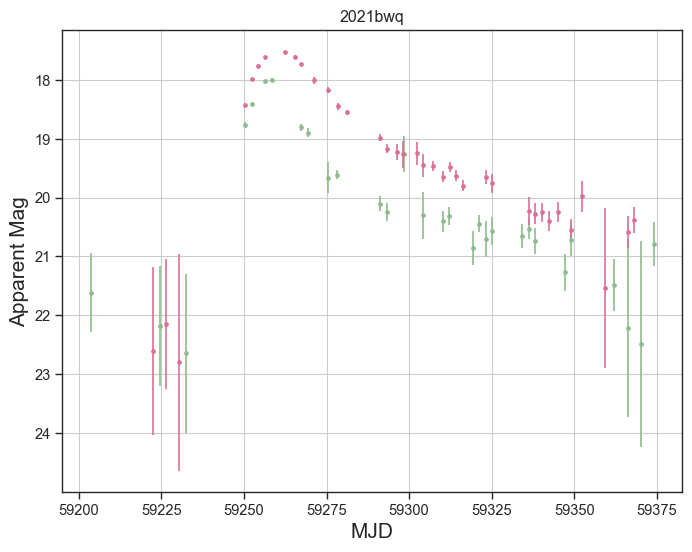

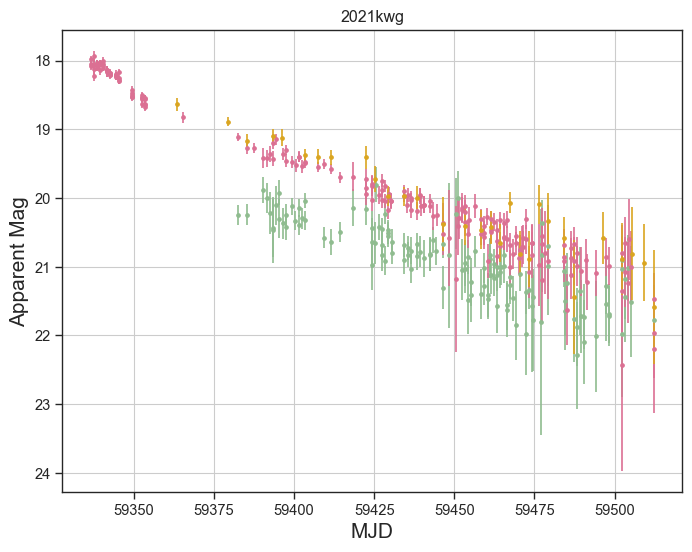

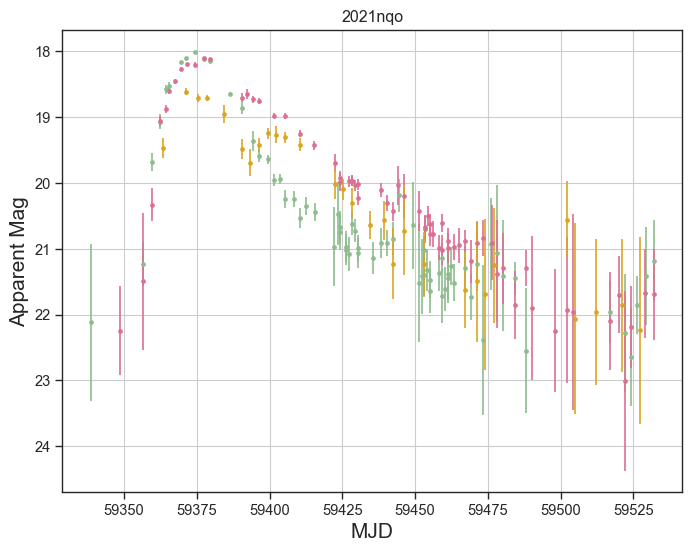

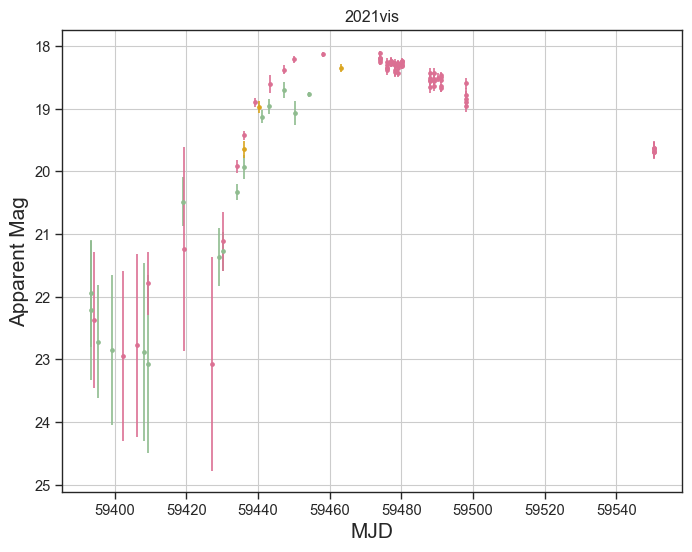

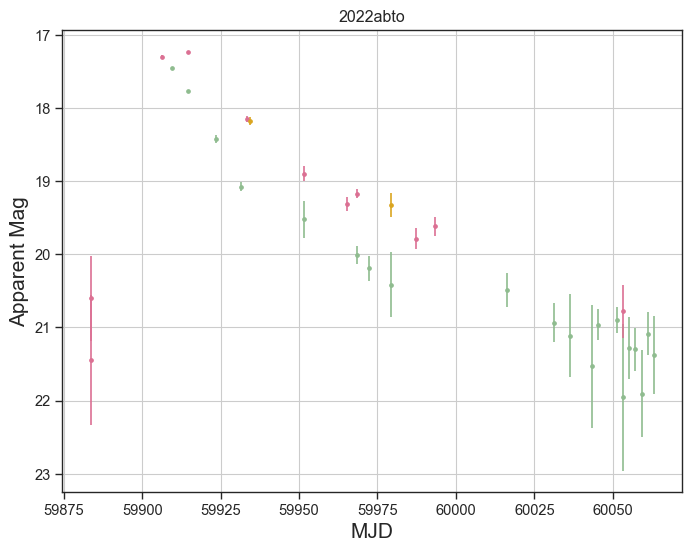

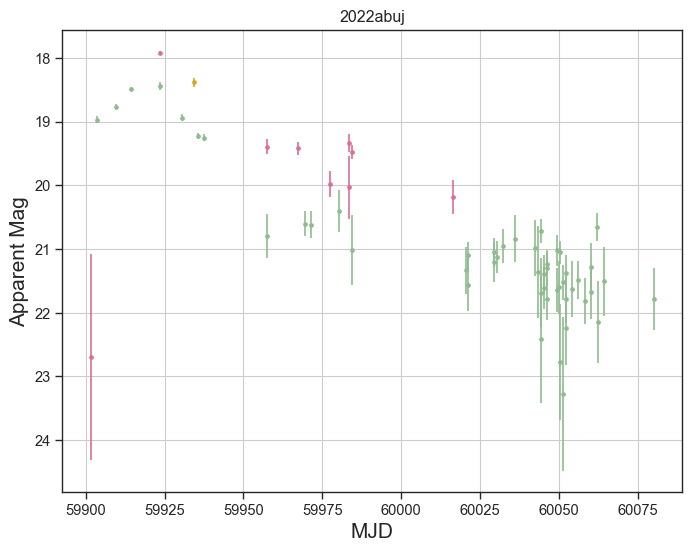

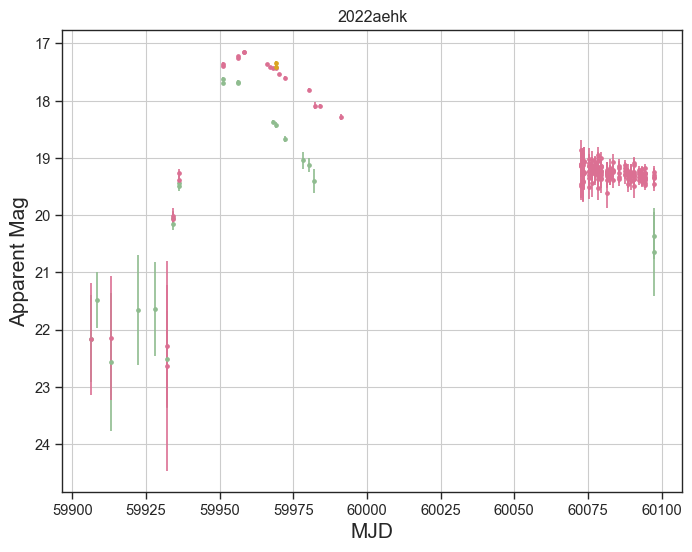

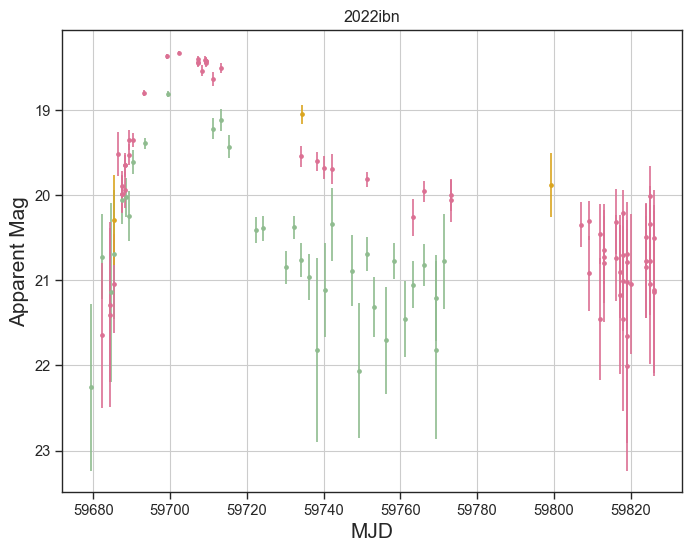

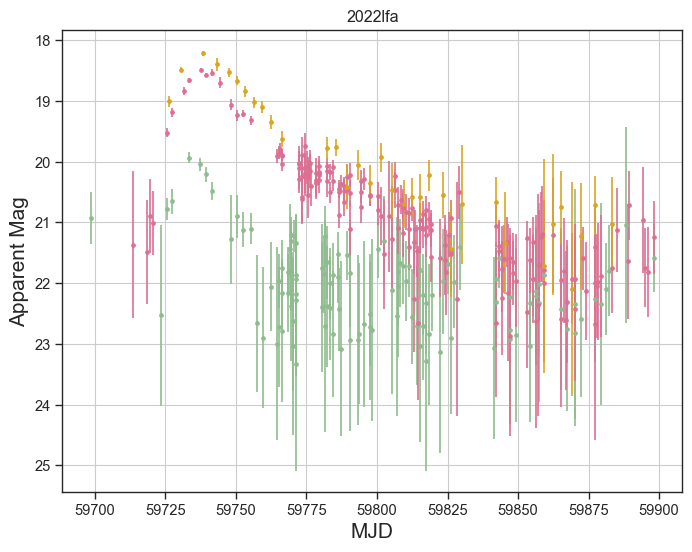

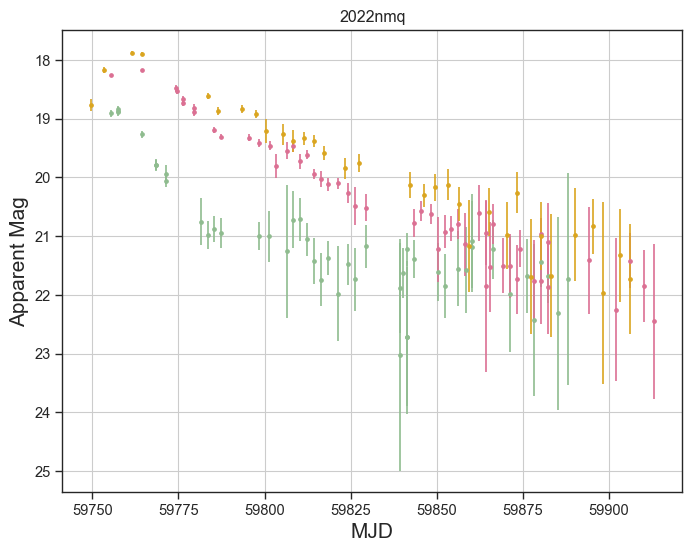

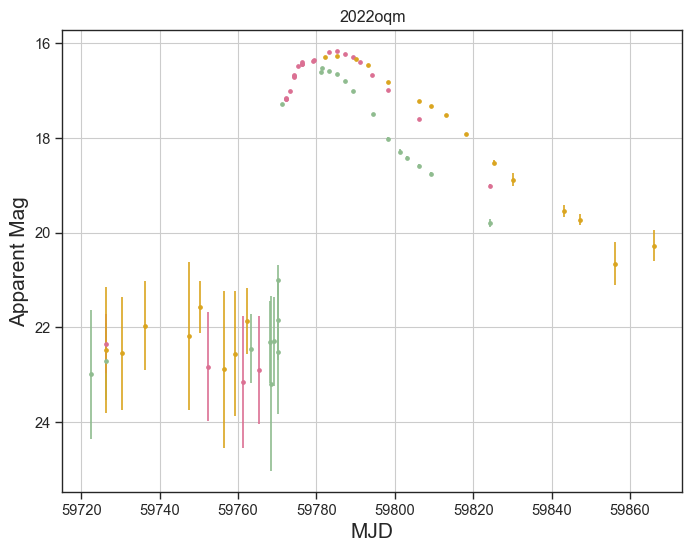

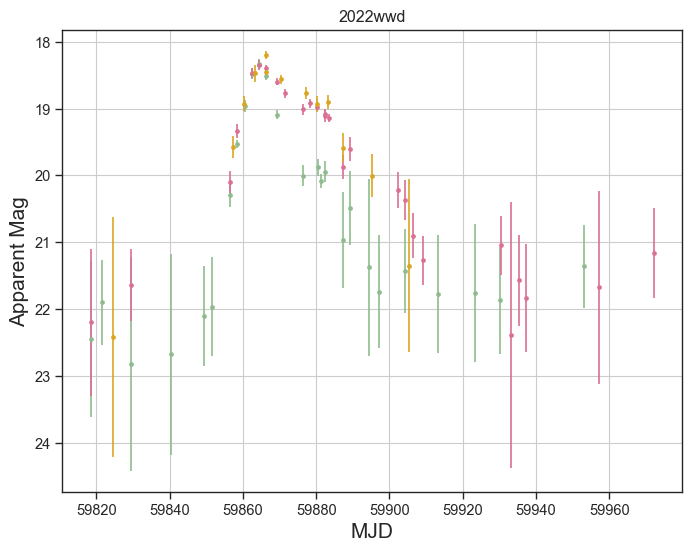

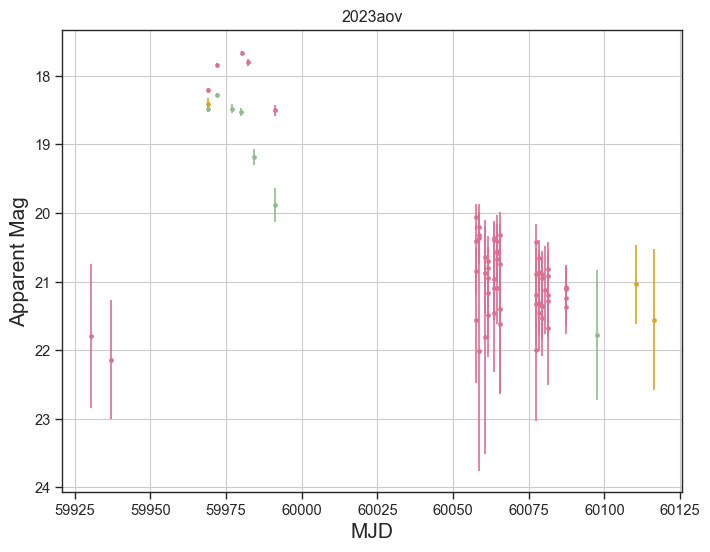

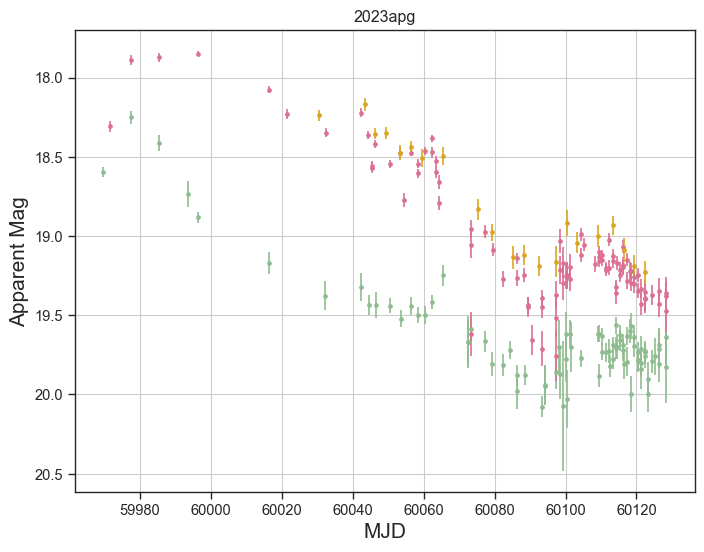

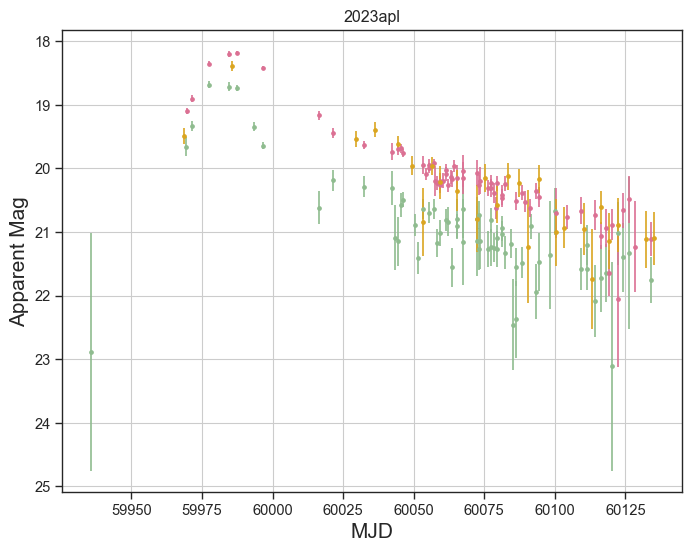

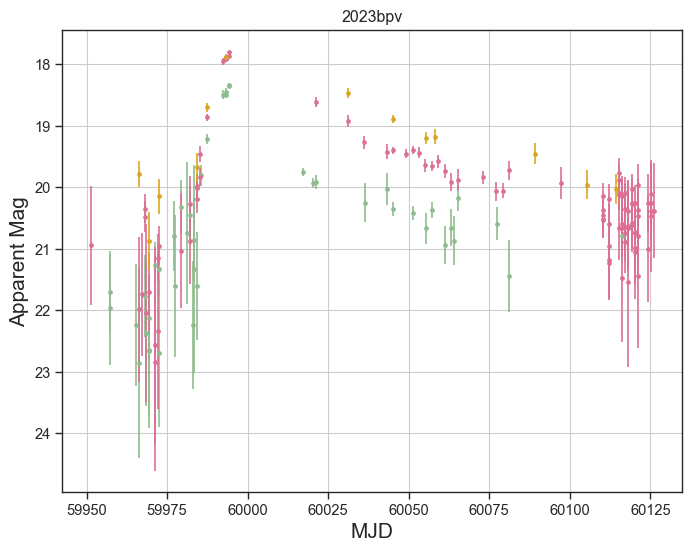

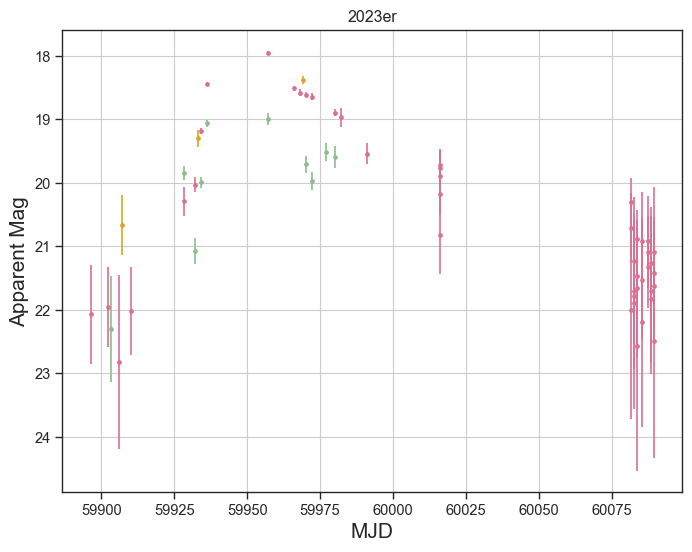

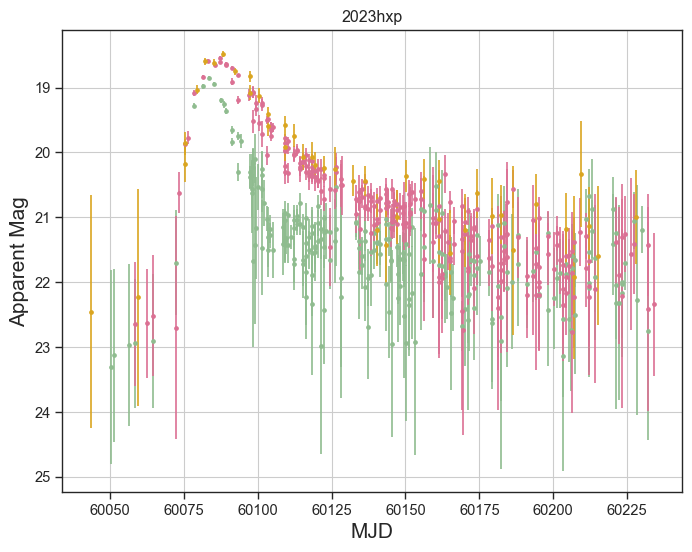

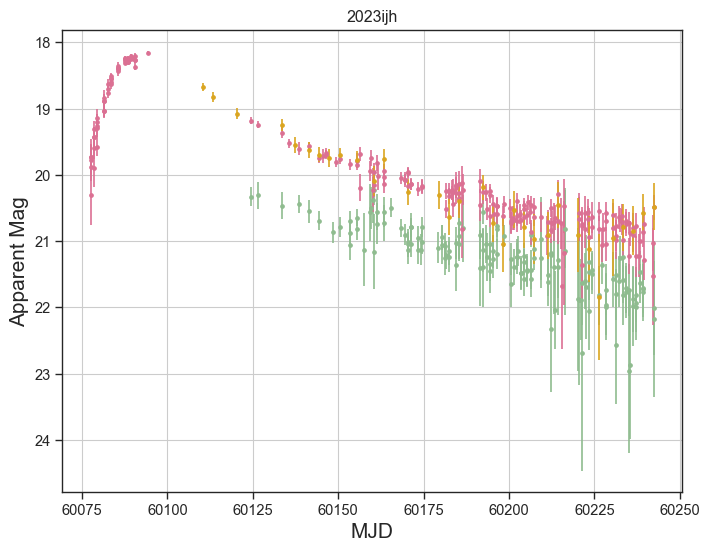

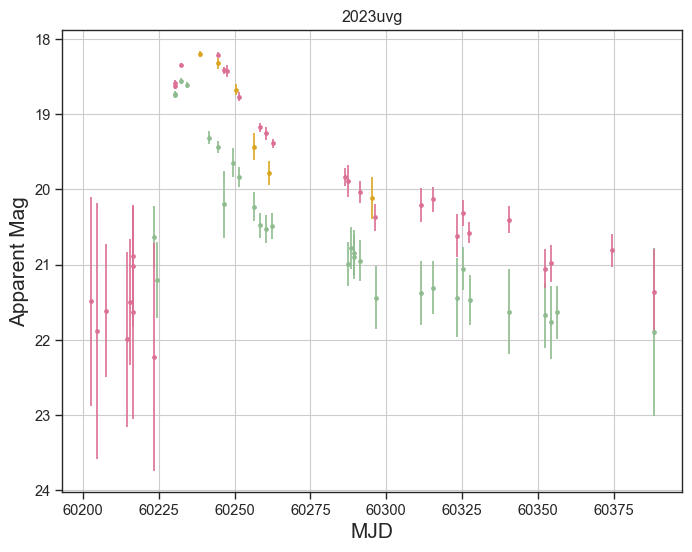

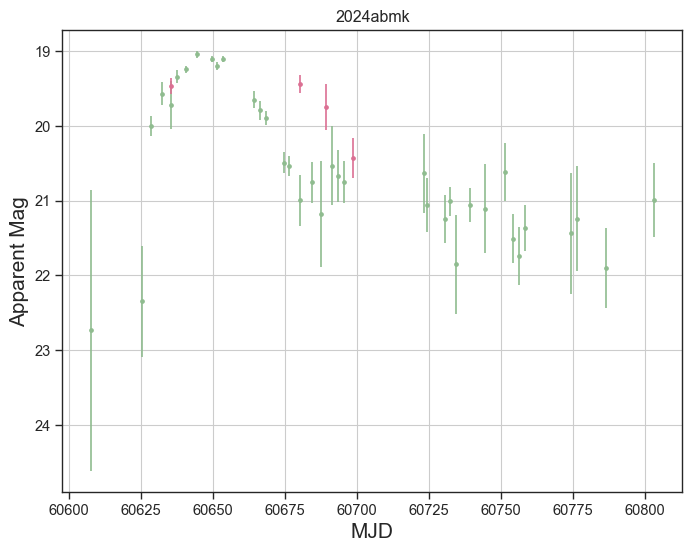

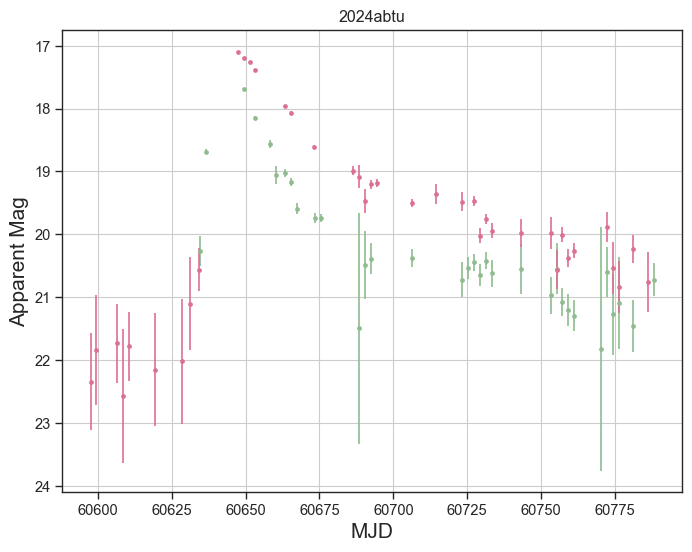

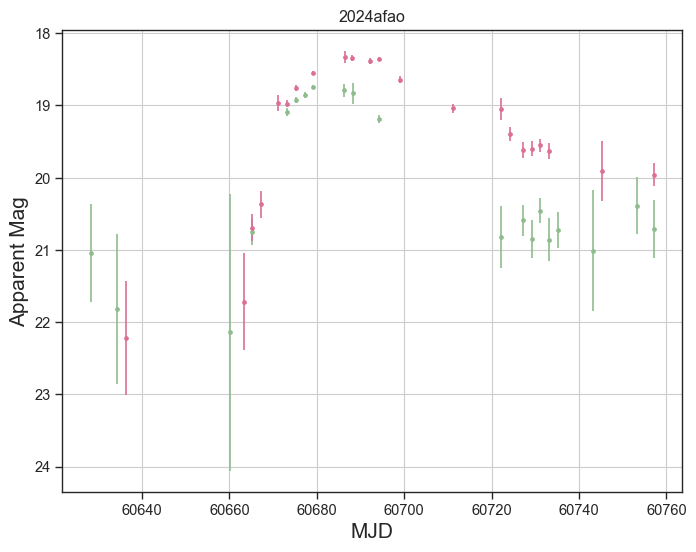

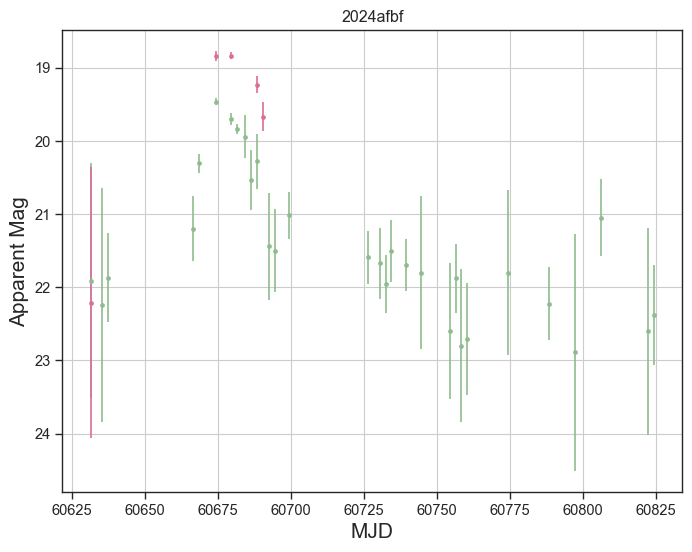

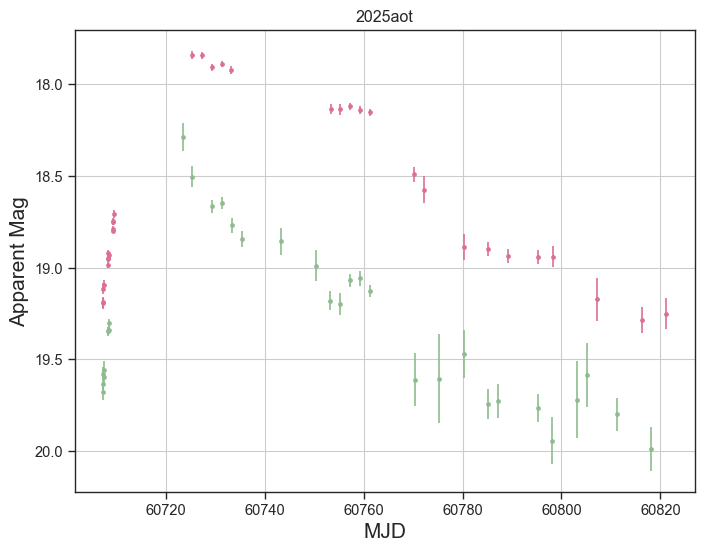

In [ ]:
# plot_all_ztf_lcs(lc_dfs_ic,sn_names_ic,save=True)

In [48]:
# plot_all_ztf_lcs(lc_dfs_iib,sn_names_iib,save=True)

In [50]:
# plot_all_ztf_lcs(lc_dfs_iin,sn_names_iin,save=True)

In [52]:
# plot_all_ztf_lcs(lc_dfs_slsni,sn_names_slsni,save=True)

In [54]:
# plot_all_ztf_lcs(lc_dfs_slsnii,sn_names_slsnii,save=True)

In [55]:
# date of max fitting for LCs

# craig's function from adap

def plot_fit_for_max(
    sn_name, # was sn_class
    mjd_array,
    mag_array,
    err_array,
    fit_mjds,
    fit_mags,
    fit_errs,
    inds_to_fit,
    ):
    """
    Takes as input arrays for MJD, mag, and err for a filter
    as well as the guess for the MJD of maximum and an array
    to shift the lightcurve over,
    and returns estimates of the peak MJD and mag at peak
    """

    fig, ax = plt.subplots()

    ax.errorbar(mjd_array, mag_array, yerr=err_array, fmt="o", color="gray", ms=1)
    ax.errorbar(
        fit_mjds,
        fit_mags,
        yerr=fit_errs,
        fmt="o",
        color="blue",
        label="Used in Fitting",
        ms=3,
    )
    if len(mjd_array[inds_to_fit]) > 0:
        plt.ylim(min(mag_array[inds_to_fit]) - 0.5, max(mag_array[inds_to_fit]) + 0.5)
    plt.xlabel("MJD")
    plt.ylabel("Apparent Magnitude")
    plt.title(sn_name)
    plt.legend()
    plt.gca().invert_yaxis()

    # plt.show()

def fit_for_max(df, sn_name, filt, shift_array=[-3, -2, -1, 0, 1, 2, 3], plot=False, offset=0, window=10):
    """
    Takes as input arrays for MJD, mag, and err for a filter
    as well as the guess for the MJD of maximum and an array
    to shift the lightcurve over,
    and returns estimates of the peak MJD and mag at peak
    """
    # mjd_array = np.asarray([phot["mjd"] for phot in self.data[filt] if not phot.get("nondetection", False)])
    # mag_array = np.asarray([phot["mag"] for phot in self.data[filt] if not phot.get("nondetection", False)])
    # err_array = np.asarray([phot["err"] for phot in self.data[filt] if not phot.get("nondetection", False)])

    mjd_array = df.loc[df['filter']==filt, 'mjd'].to_numpy()
    mag_array = df.loc[df['filter']==filt, 'mag'].to_numpy()
    err_array = df.loc[df['filter']==filt, 'e_mag'].to_numpy()

    if len(mag_array) < 4:  # == 0:
        print('len(mag)<4')
        return None, None

    initial_guess_mjd_max = mjd_array[np.where((mag_array == min(mag_array)))[0]][0] + offset

    fit_inds = np.where((abs(mjd_array - initial_guess_mjd_max) < 40))[0] #was 30
    if len(fit_inds) < 4:
        print('not enough points +/-30 days from initial guess')
        return None, None

    fit_coeffs = np.polyfit(mjd_array[fit_inds], mag_array[fit_inds], 3)
    guess_phases = np.arange(min(mjd_array[fit_inds]), max(mjd_array[fit_inds]), 1)
    p = np.poly1d(fit_coeffs)
    guess_best_fit = p(guess_phases)

    if len(guess_best_fit) == 0:
        print('len(best_guess)=0')
        return None, None

    guess_mjd_max = guess_phases[np.where((guess_best_fit == min(guess_best_fit)))[0]][0]

    # print(f'GUESS MJD MAX = {guess_mjd_max}')
    ### Do this because the array might not be ordered
    inds_to_fit = np.where((mjd_array > guess_mjd_max - window) & (mjd_array < guess_mjd_max + window))
    # print(f'INDS_TO_FIt = {inds_to_fit}')
    
    if len(inds_to_fit[0]) < 4:
        print('Select a wider date range')
        return None, None

    numdata = len(mjd_array[inds_to_fit])
    numiter = max(int(numdata * np.log(numdata) ** 2), 200)

    fit_mjds = mjd_array[inds_to_fit]
    fit_mags = mag_array[inds_to_fit]
    fit_errs = err_array[inds_to_fit]

    if plot:
        plot_fit_for_max(
            sn_name=sn_name,
            mjd_array=mjd_array,
            mag_array=mag_array,
            err_array=err_array,
            fit_mjds=fit_mjds,
            fit_mags=fit_mags,
            fit_errs=fit_errs,
            inds_to_fit=inds_to_fit,
        )

    peak_mags = []
    peak_mjds = []
    for num in range(numiter):
        simulated_points = []

        ### Shift by a certain number of days to randomly sample the light curve
        sim_shift = np.random.choice(shift_array)

        inds_to_fit = np.where((mjd_array > guess_mjd_max - (window/2) + sim_shift) & (mjd_array < guess_mjd_max + (window/2) + sim_shift))[0]
        if len(inds_to_fit) > 0:

            fit_mjds = mjd_array[inds_to_fit]
            fit_mags = mag_array[inds_to_fit]
            fit_errs = err_array[inds_to_fit]

            for i in range(len(fit_mjds)):
                simulated_points.append(np.random.normal(fit_mags[i], fit_errs[i]))

            fit = np.polyfit(fit_mjds, simulated_points, 2)
            f = np.poly1d(fit)
            fit_time = np.linspace(min(fit_mjds), max(fit_mjds), 100)

            if num % 25 == 0 and plot:
                plt.plot(fit_time, f(fit_time), color="black", linewidth=0.5)
            peak_mag = min(f(fit_time))
            peak_mags.append(peak_mag)
            peak_mjds.append(fit_time[np.argmin(f(fit_time))])

    if len(peak_mjds) == 0:
        print('len(peak_mjds)=0')
        return None, None

    if plot:
        plt.errorbar(
            mean(peak_mjds),
            mean(peak_mags),
            xerr=stdev(peak_mjds),
            yerr=stdev(peak_mags),
            color="red",
            fmt="o",
            label="Best Fit Peak",
        )
        plt.xlim(guess_mjd_max - 30, guess_mjd_max + 30)
        plt.legend()
        plt.show()

    return mean(peak_mjds), mean(peak_mags)

In [56]:
# %matplotlib qt

def fit_max(
        dfs,
        sn_names,
        savefile,
        plot=True,
        first_fit=False,
        refit_r=False,
        refit_g=False,
        inds_to_fit=[],
        save2file=False,
        window=10,
        ):
          
    if first_fit:
        #initialize savefile
        with open(savefile, 'a') as file:
            file.write('#sn_name peak_mjd peak_mag filt\n')
        file.close()

        filt = 'ZTF_g'

        for i,df in enumerate(dfs):
            sn_name = sn_names[i]
            print(i, sn_name)

            peak_mjd, peak_mag = fit_for_max(df, sn_name, filt,
                                             shift_array=[-3, -2, -1, 0, 1, 2, 3],
                                             plot=plot, offset=0, window=window)
            print(peak_mjd, peak_mag)

            if save2file:
                line = f'{sn_name} {peak_mjd} {peak_mag} {filt}\n'
                with open(savefile, 'a') as file:
                    file.write(line)
                file.close()

    elif refit_r:
        filt = 'ZTF_r'
        if not inds_to_fit:
            print('Must include indeces to slice on')
            return
        
        for i,df in enumerate(dfs):
            if any(i == x for x in inds_to_fit):
                sn_name = sn_names[i]
                print(i, sn_name)

                peak_mjd, peak_mag = fit_for_max(df, sn_name, filt,
                                                 shift_array=[-3, -2, -1, 0, 1, 2, 3],
                                                 plot=plot, offset=0, window=window)
                print(peak_mjd, peak_mag)

                if save2file:
                    line = f'{sn_name} {peak_mjd} {peak_mag} {filt}\n'
                    with open(savefile, 'a') as file:
                        file.write(line)
                    file.close()

    elif refit_g:
        filt = 'ZTF_g'
        if not inds_to_fit:
            print('Must include indeces to slice on')
            return
        
        for i,df in enumerate(dfs):
            if any(i == x for x in inds_to_fit):
                sn_name = sn_names[i]
                print(i, sn_name)

                peak_mjd, peak_mag = fit_for_max(df, sn_name, filt,
                                                 shift_array=[-3, -2, -1, 0, 1, 2, 3],
                                                 plot=plot, offset=0, window=window)
                print(peak_mjd, peak_mag)

                if save2file:
                    line = f'{sn_name} {peak_mjd} {peak_mag} {filt}\n'
                    with open(savefile, 'a') as file:
                        file.write(line)
                    file.close()

In [ ]:
#fitting max of LC for Ib

savefile = './ztf_fp_data/peak_fit_ib.txt'

# refit_g_inds = []
# refit_r_inds = []

fit_max(lc_dfs_ib, sn_names_ib, savefile, plot=False, first_fit=False,
        refit_r=False, refit_g=False, inds_to_fit=[],
        save2file=False, window=15) #window = 15 for first fit

In [ ]:
#fitting max of LC for Ic

savefile = './ztf_fp_data/peak_fit_ic.txt'

# refit_g_inds = []
# refit_r_inds = []

fit_max(lc_dfs_ic, sn_names_ic, savefile, plot=False, first_fit=False,
        refit_r=False, refit_g=False, inds_to_fit=[],
        save2file=False, window=15) #window = 15 for first fit

In [ ]:
#fitting max of LC for IIb

savefile = './ztf_fp_data/peak_fit_iib.txt'

# refit_g_inds = []
# refit_r_inds = []

fit_max(lc_dfs_iib, sn_names_iib, savefile, plot=False, first_fit=False,
        refit_r=False, refit_g=False, inds_to_fit=[],
        save2file=False, window=15) #window = 15 for first fit

In [ ]:
#fitting max of LC for IIn

savefile = './ztf_fp_data/peak_fit_iin.txt'

# refit_g_inds = []
# refit_r_inds = []

fit_max(lc_dfs_iin, sn_names_iin, savefile, plot=False, first_fit=False,
        refit_r=False, refit_g=False, inds_to_fit=[],
        save2file=False, window=15) #window = 15 for first fit

In [ ]:
#fitting max of LC for SLSN-I

savefile = './ztf_fp_data/peak_fit_slsni.txt'

# refit_g_inds = []
# refit_r_inds = []

fit_max(lc_dfs_slsni, sn_names_slsni, savefile, plot=False, first_fit=False,
        refit_r=False, refit_g=False, inds_to_fit=[],
        save2file=False, window=15) #window = 15 for first fit

In [ ]:
#fitting max of LC for SLSN-II

savefile = './ztf_fp_data/peak_fit_slsnii.txt'

# refit_g_inds = []
# refit_r_inds = []

fit_max(lc_dfs_slsnii, sn_names_slsnii, savefile, plot=False, first_fit=False,
        refit_r=False, refit_g=False, inds_to_fit=[],
        save2file=False, window=15) #window = 15 for first fit